## FontStyleGAN


### Setup

In [43]:
%load_ext autoreload
%autoreload 2

# Core libraries
import numpy as np
import torch

from util import show_grayscale_image
%matplotlib inline

USE_GPU = True

data_type = torch.FloatTensor

if USE_GPU and torch.cuda.is_available():
    data_type = torch.cuda.FloatTensor

print(torch.cuda.memory_allocated())

glyph_size = (16, 16)
glyphs_per_image = 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
159106560


In [67]:
from data.font_dataset import FontDataset
from data.font_data_loader import FontDataLoader

dataset = FontDataset('./datasets/fonts/', glyph_size=glyph_size, glyphs_per_image=glyphs_per_image)
print(dataset[0].shape)

# Show what a normalized image looks like.
show_grayscale_image(dataset[0])

torch.Size([1, 16, 416])


torch.Size([1, 16, 16])


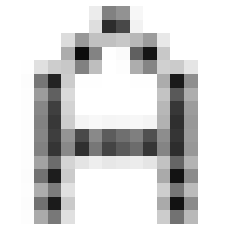

In [68]:
single_image = dataset[0][:,:,0:glyph_size[1]]
print(single_image.shape)

# Sample a specific image
show_grayscale_image(single_image)

In [69]:
from models.models import build_font_shape_generator, build_font_shape_discriminator, get_optimizer, initialize_weights
from train import train
from models.loss import wasserstein_loss, min_max_loss, l1_loss

def train_network(D_loss, G_loss, batch_size, epoch_count, filter_dimension):
    print(torch.cuda.memory_allocated())

    G = build_font_shape_generator(
        glyph_size=glyph_size,
        glyph_count=glyphs_per_image,
        dimension=filter_dimension
    )
    print(G)

    G_optimizer = get_optimizer(G)
    G.apply(initialize_weights)

    D = build_font_shape_discriminator(image_size=(glyph_size[0], glyph_size[1] * glyphs_per_image))

    D_optimizer = get_optimizer(D)
    D.apply(initialize_weights)

    data_loader = FontDataLoader(dataset, sampler=None, batch_size=batch_size)

    if USE_GPU and torch.cuda.is_available():
        G.cuda()
        D.cuda()
    
    options = {
        'batch_size': batch_size,
        'epoch_count': epoch_count,
        'data_type': data_type,
        'glyph_size': glyph_size,
        'glyphs_per_image': glyphs_per_image
    }
    
    train(D, G, D_optimizer, G_optimizer, D_loss, G_loss, data_loader, options)
    
    return D, G

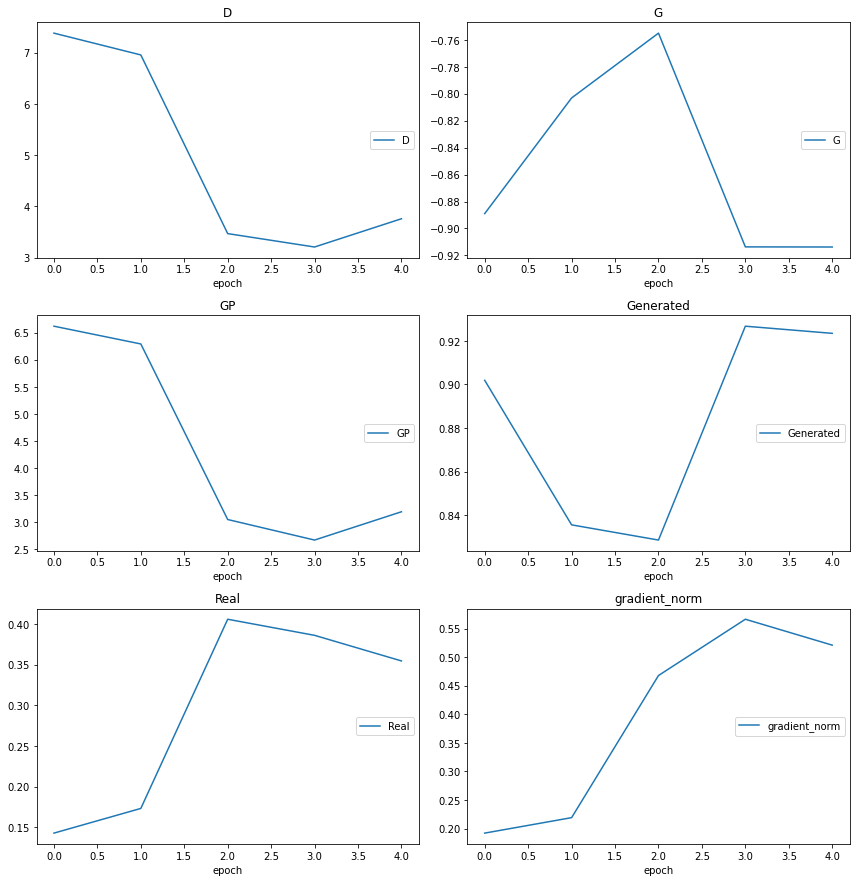

D
	D                	 (min:    3.208, max:    7.378, cur:    3.759)
G
	G                	 (min:   -0.914, max:   -0.755, cur:   -0.914)
GP
	GP               	 (min:    2.667, max:    6.619, cur:    3.190)
Generated
	Generated        	 (min:    0.829, max:    0.927, cur:    0.923)
Real
	Real             	 (min:    0.143, max:    0.406, cur:    0.355)
gradient_norm
	gradient_norm    	 (min:    0.192, max:    0.566, cur:    0.521)


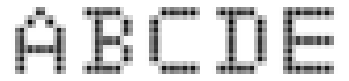

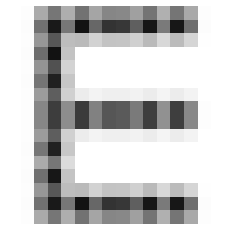

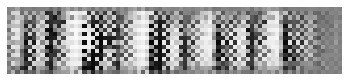

(Sequential(
   (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (1): LeakyReLU(negative_slope=0.2)
   (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (3): LeakyReLU(negative_slope=0.2)
   (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (5): LeakyReLU(negative_slope=0.2)
   (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (7): LeakyReLU(negative_slope=0.2)
   (8): Flatten()
   (9): Linear(in_features=640, out_features=1, bias=True)
   (10): Sigmoid()
 ),
 Sequential(
   (0): Conv2d(1, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (1): LeakyReLU(negative_slope=0.2)
   (2): Conv2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (3): LeakyReLU(negative_slope=0.2)
   (4): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (5): LeakyReLU(negative_slope=0.2)
   (6): Flatten()
   (7): Linear(in_features=512, out_features=256, bias=True)
   (8):

In [72]:
train_network(D_loss=wasserstein_loss, G_loss=min_max_loss, batch_size=64, epoch_count=5, filter_dimension=512)

## A shift in strategy

In the above example, we use a GAN in order to generate an alphabet, based on a single letter. As made evident from above, this is not an easy task. As it stands:

1. We use the Wasserstein Distance (weight-mover) in order to calculate the loss.
2. We apply a gradient penalty in order to help normalize the loss and ease training.

But the results are obvious:

1. Generator loss remains high, and discriminator eventually "gives up" and accepts anything that is a rough blob. **OPEN QUESTION**: Why?
2. Training time is lengthy.

So what if we only trained a generator? This is a simpler approach, and maybe a little more pedestrian, but perhaps we can make it work?

### L1 Loss
Rather than using a Discriminator, we only use a **Generator** in the below box -- we don't need to add complexity during training right now, if the relationship between source input and desired output is straight forward (as it should be with fonts.)

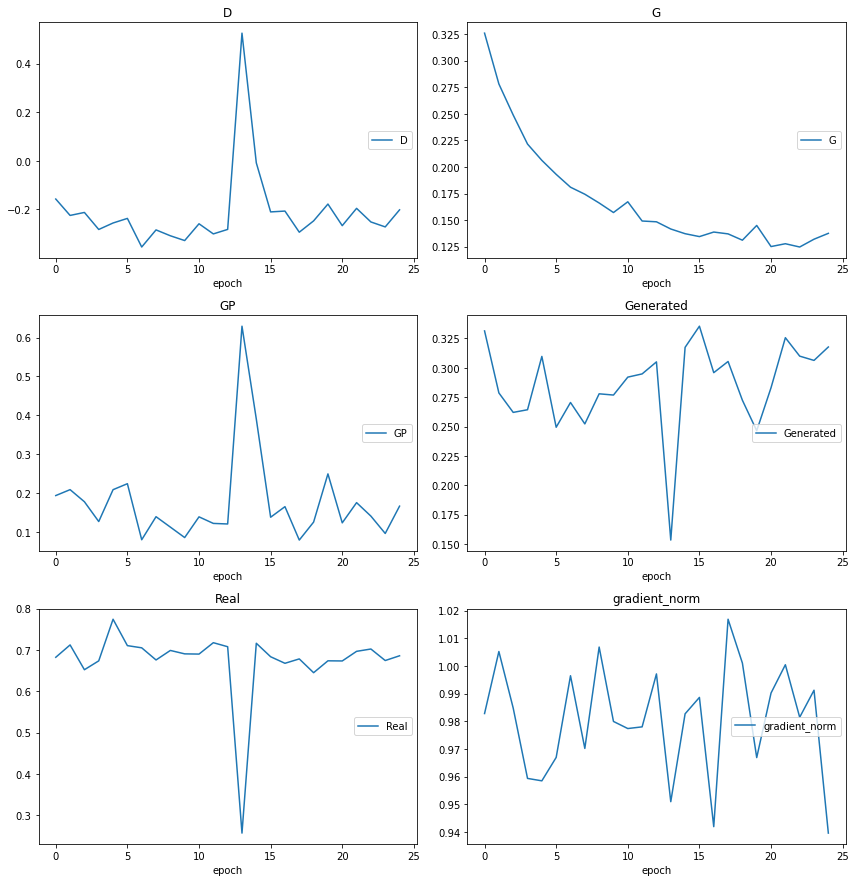

D
	D                	 (min:   -0.355, max:    0.526, cur:   -0.202)
G
	G                	 (min:    0.125, max:    0.326, cur:    0.138)
GP
	GP               	 (min:    0.079, max:    0.629, cur:    0.166)
Generated
	Generated        	 (min:    0.153, max:    0.335, cur:    0.318)
Real
	Real             	 (min:    0.257, max:    0.774, cur:    0.686)
gradient_norm
	gradient_norm    	 (min:    0.940, max:    1.017, cur:    0.940)


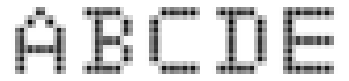

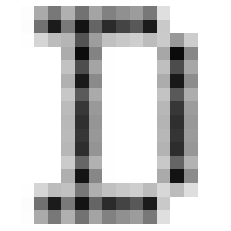

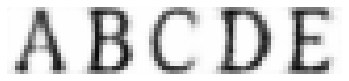

In [76]:
SuperD, SuperG = train_network(D_loss=wasserstein_loss, G_loss=l1_loss, batch_size=64, epoch_count=25, filter_dimension=215)

# from torch.utils.data.sampler import SubsetRandomSampler
# from train import train_2

# validation_size = 0.1
# font_count = len(dataset)
# indices = list(range(font_count))
# split = int(np.floor(validation_size * font_count))

# train_indices = indices[split:]
# test_indices = indices[:split]
# train_sampler = SubsetRandomSampler(train_indices)
# test_sampler = SubsetRandomSampler(test_indices)

# train_loader = FontDataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
# test_loader = FontDataLoader(dataset, sampler=test_sampler, batch_size=batch_size)
    
# train_2(G, G_optimizer, batch_size, epoch_count, train_loader, data_type, glyph_size, glyphs_per_image)

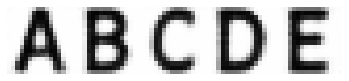

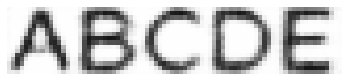

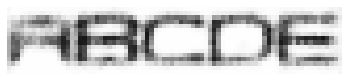

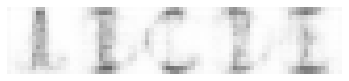

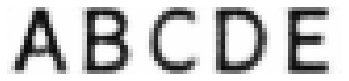

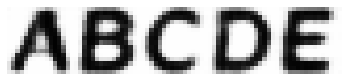

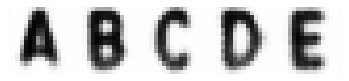

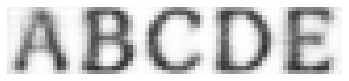

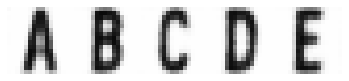

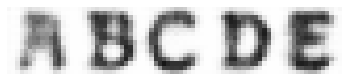

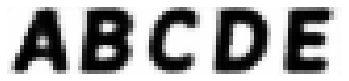

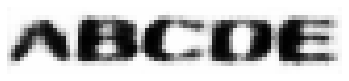

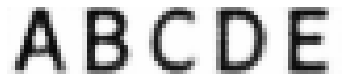

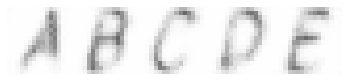

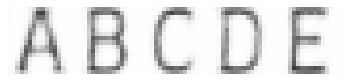

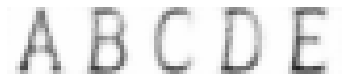

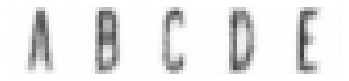

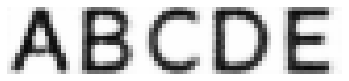

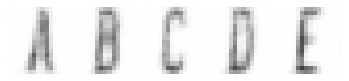

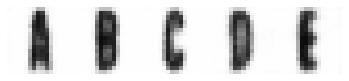

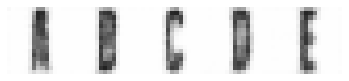

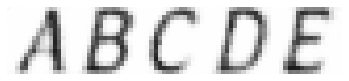

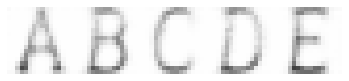

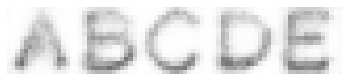

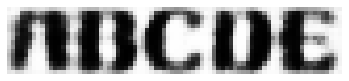

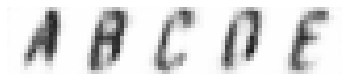

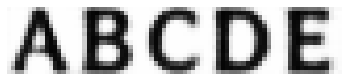

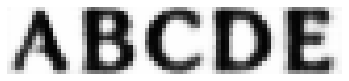

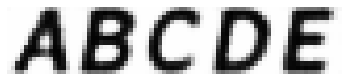

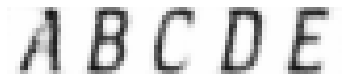

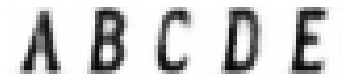

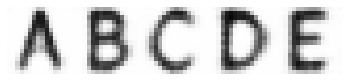

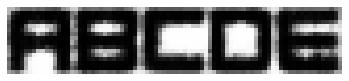

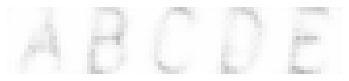

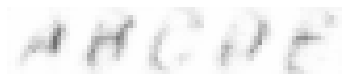

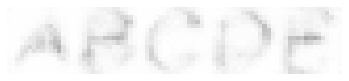

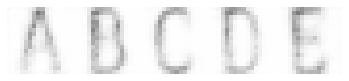

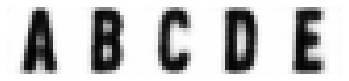

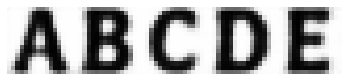

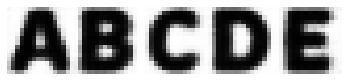

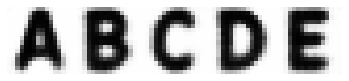

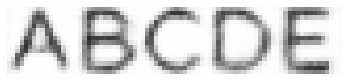

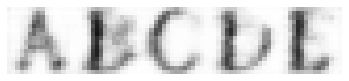

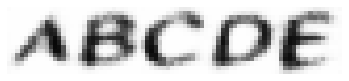

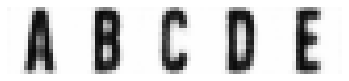

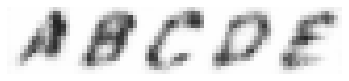

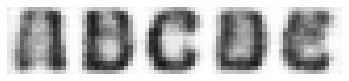

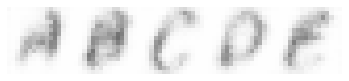

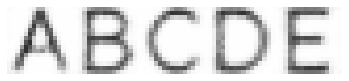

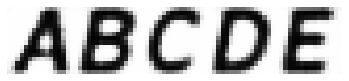

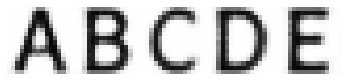

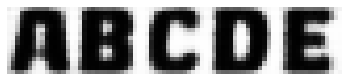

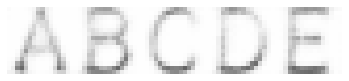

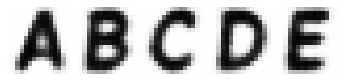

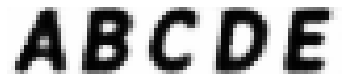

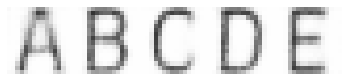

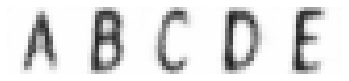

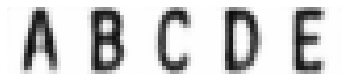

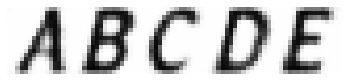

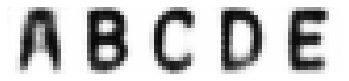

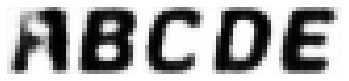

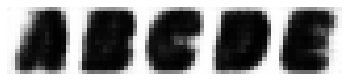

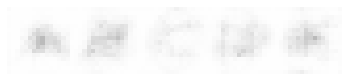

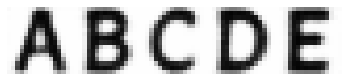

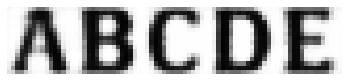

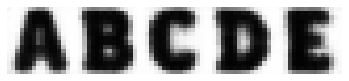

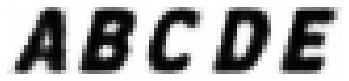

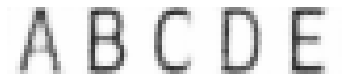

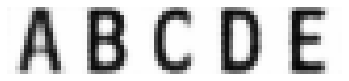

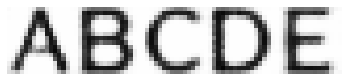

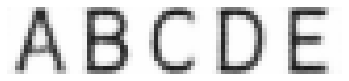

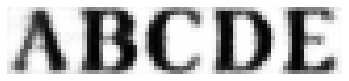

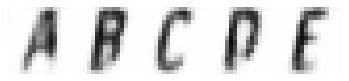

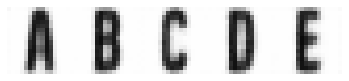

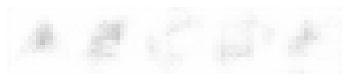

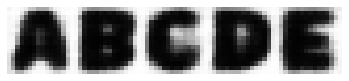

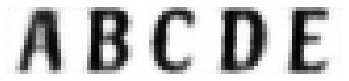

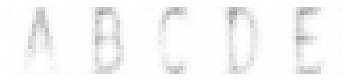

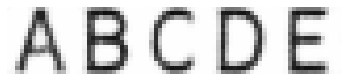

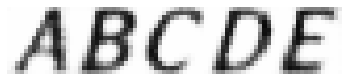

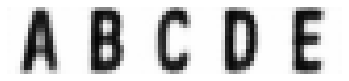

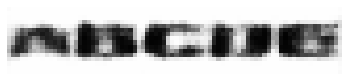

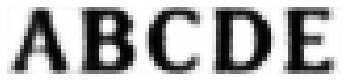

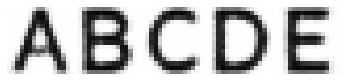

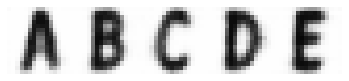

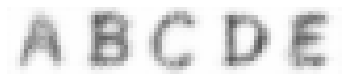

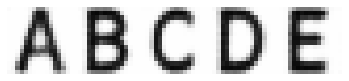

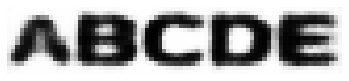

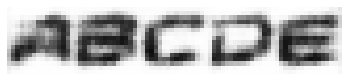

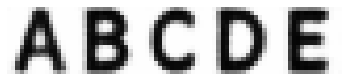

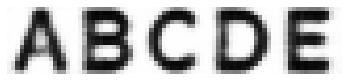

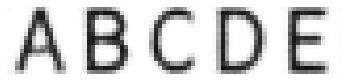

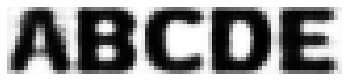

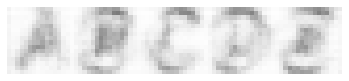

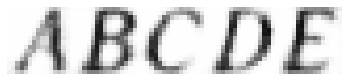

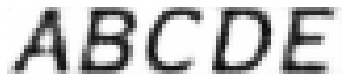

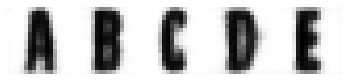

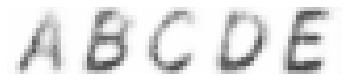

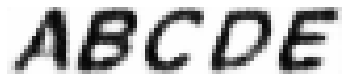

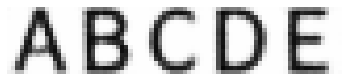

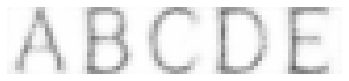

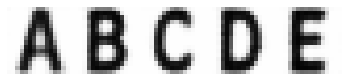

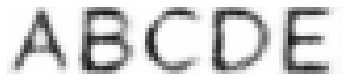

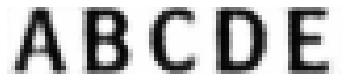

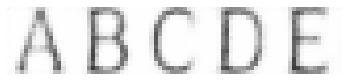

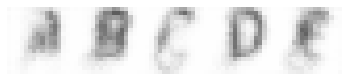

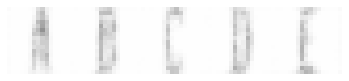

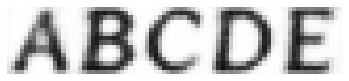

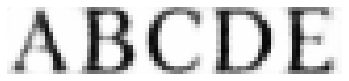

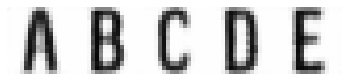

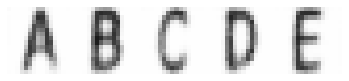

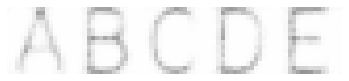

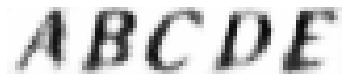

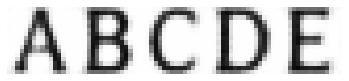

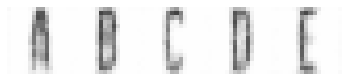

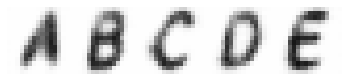

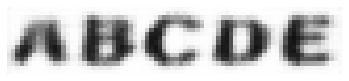

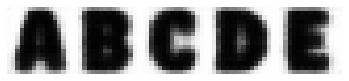

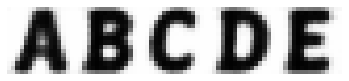

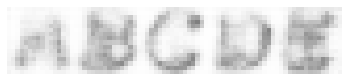

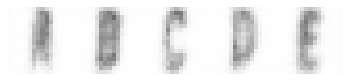

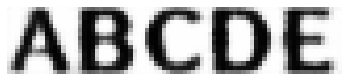

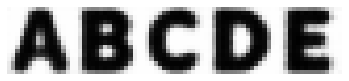

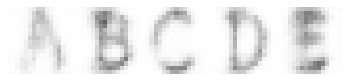

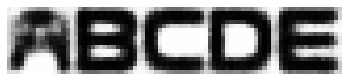

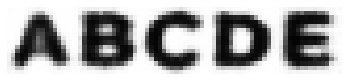

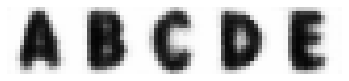

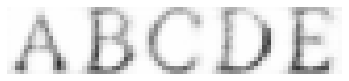

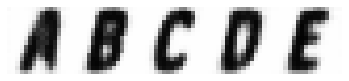

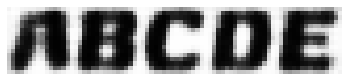

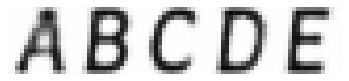

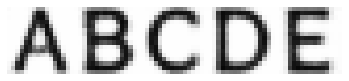

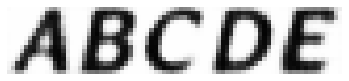

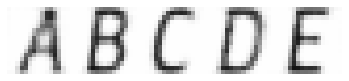

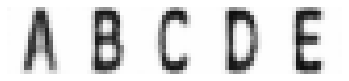

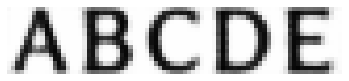

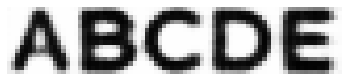

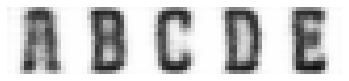

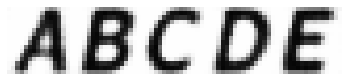

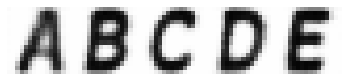

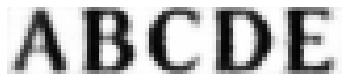

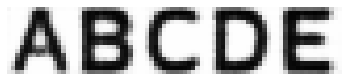

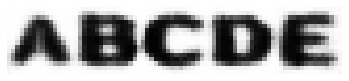

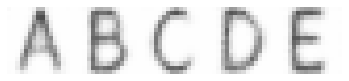

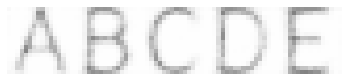

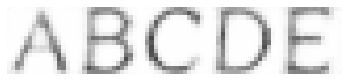

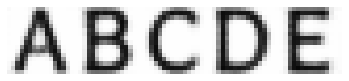

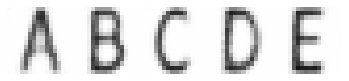

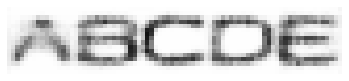

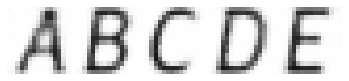

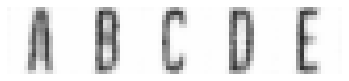

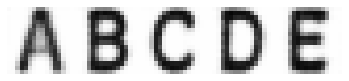

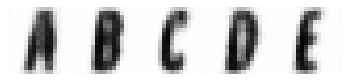

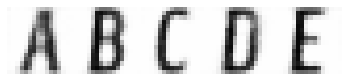

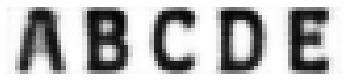

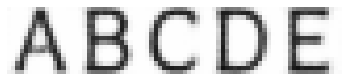

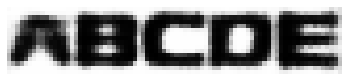

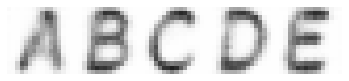

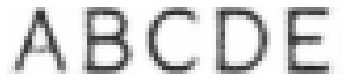

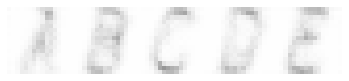

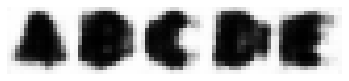

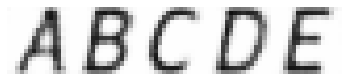

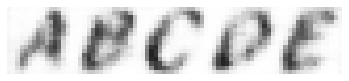

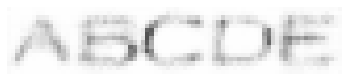

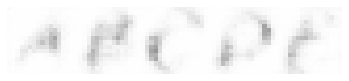

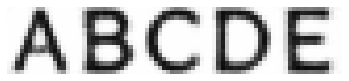

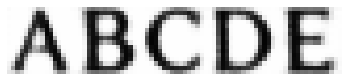

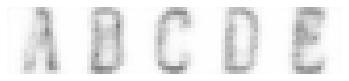

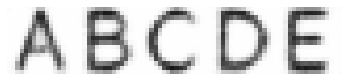

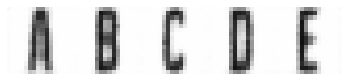

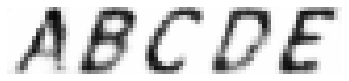

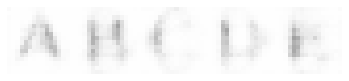

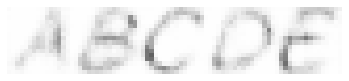

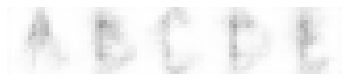

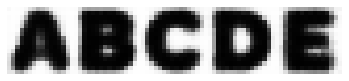

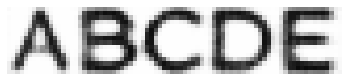

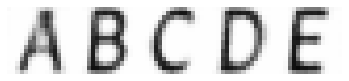

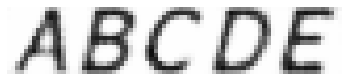

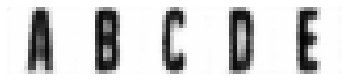

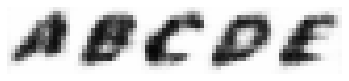

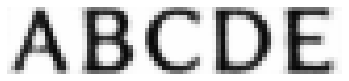

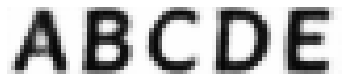

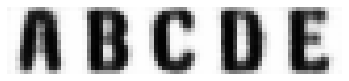

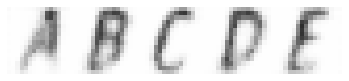

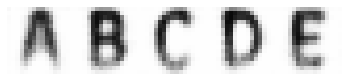

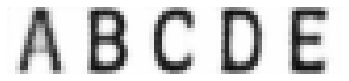

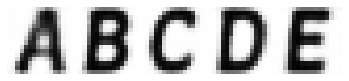

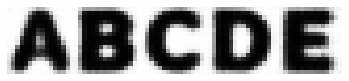

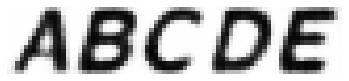

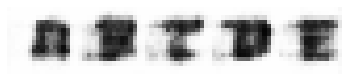

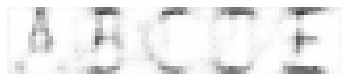

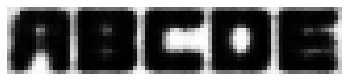

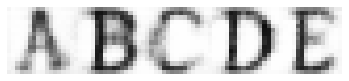

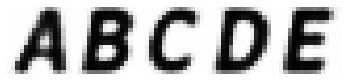

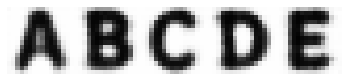

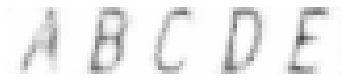

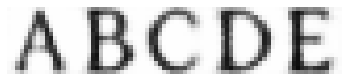

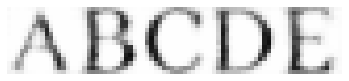

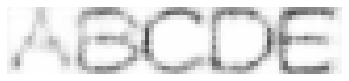

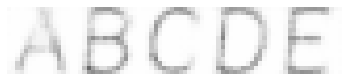

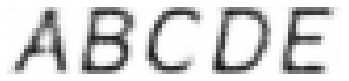

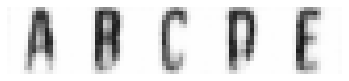

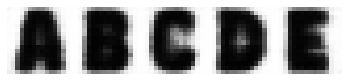

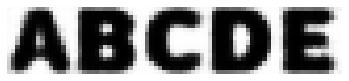

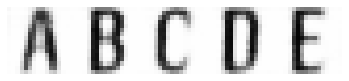

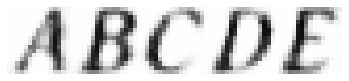

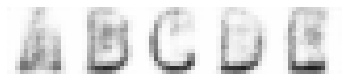

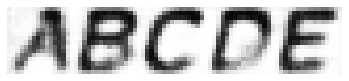

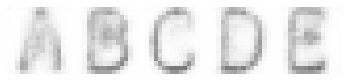

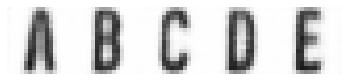

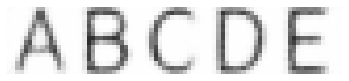

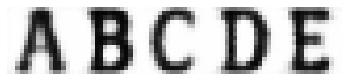

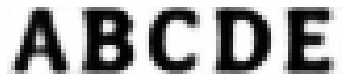

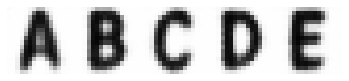

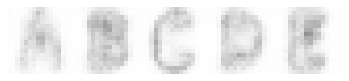

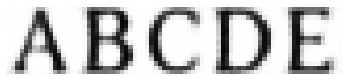

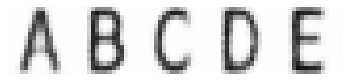

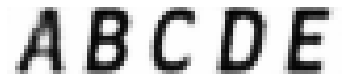

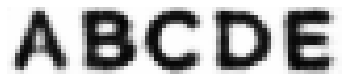

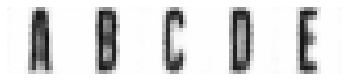

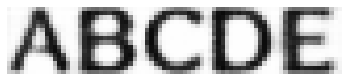

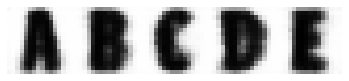

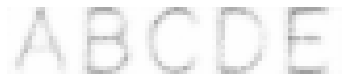

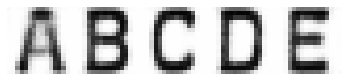

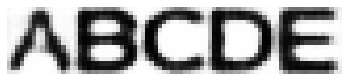

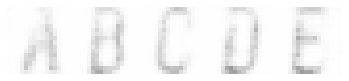

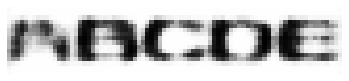

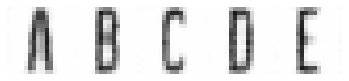

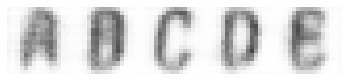

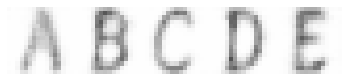

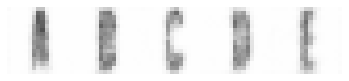

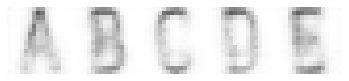

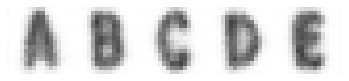

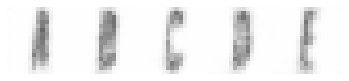

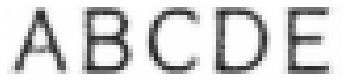

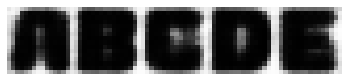

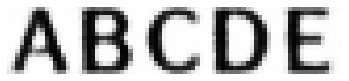

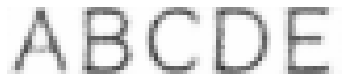

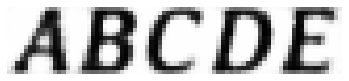

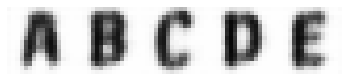

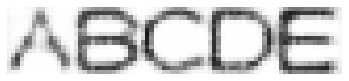

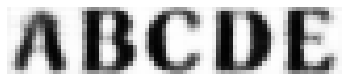

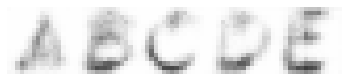

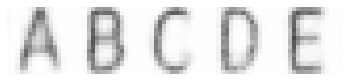

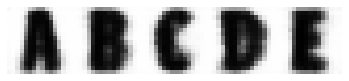

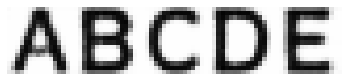

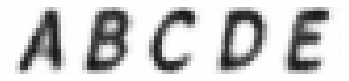

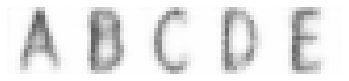

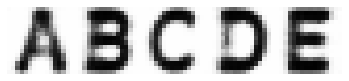

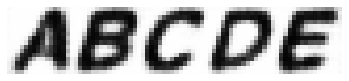

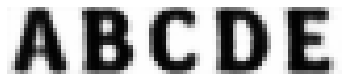

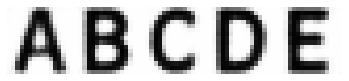

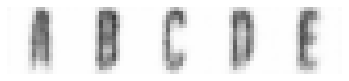

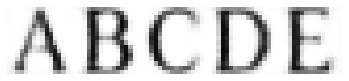

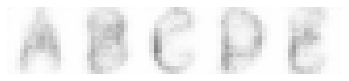

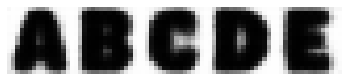

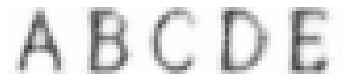

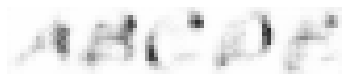

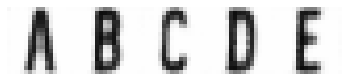

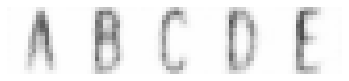

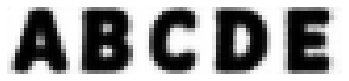

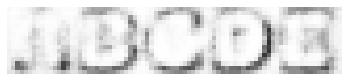

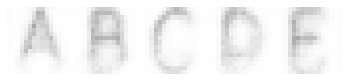

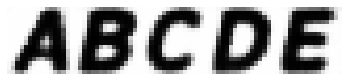

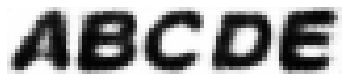

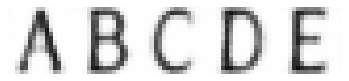

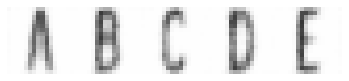

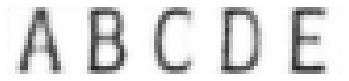

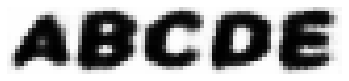

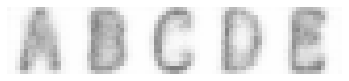

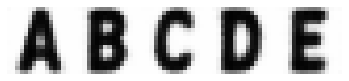

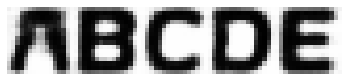

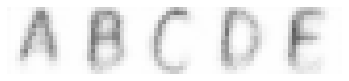

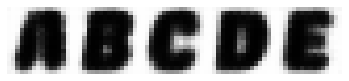

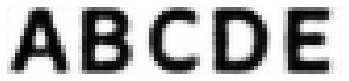

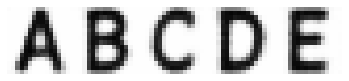

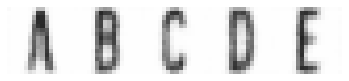

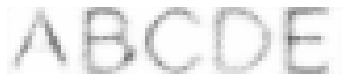

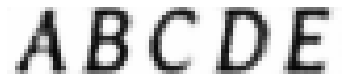

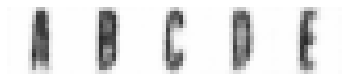

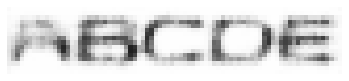

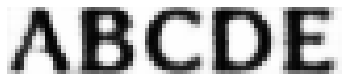

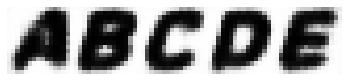

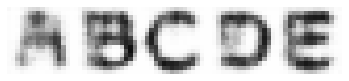

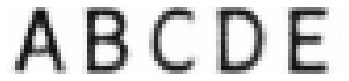

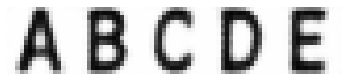

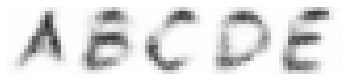

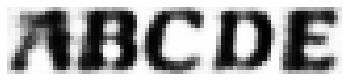

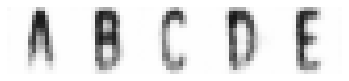

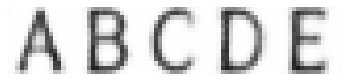

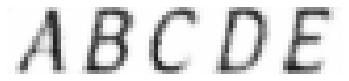

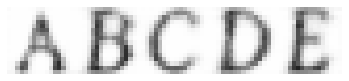

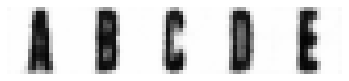

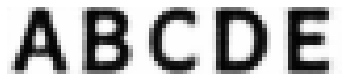

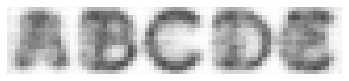

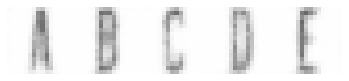

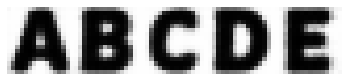

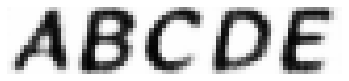

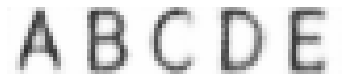

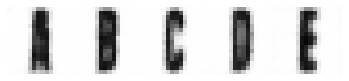

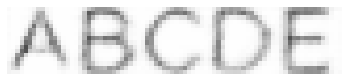

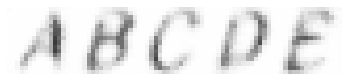

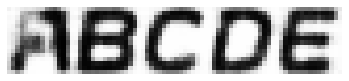

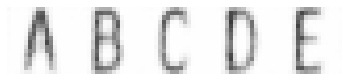

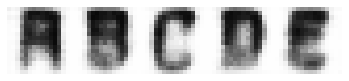

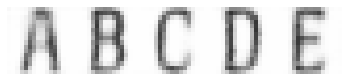

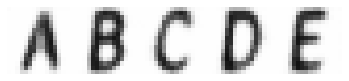

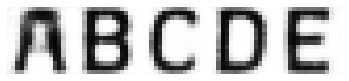

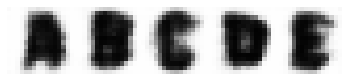

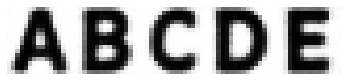

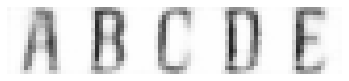

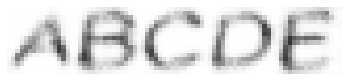

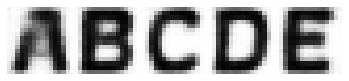

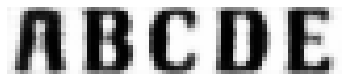

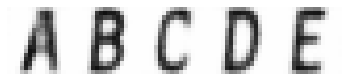

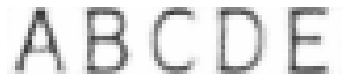

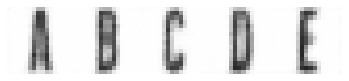

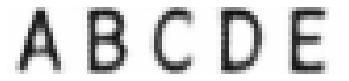

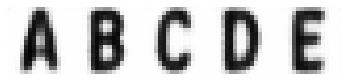

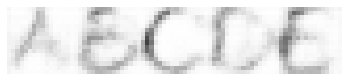

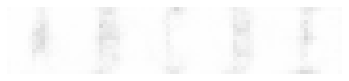

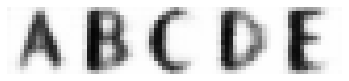

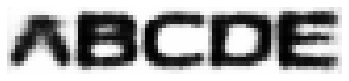

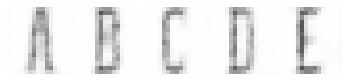

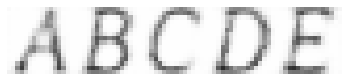

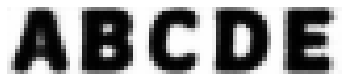

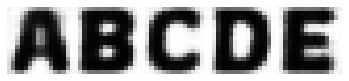

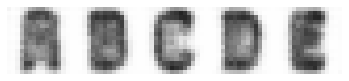

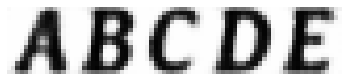

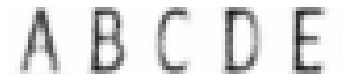

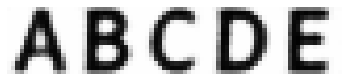

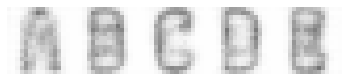

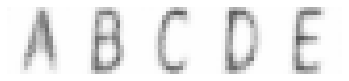

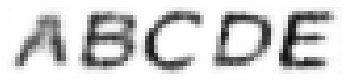

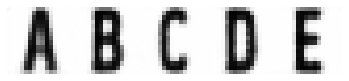

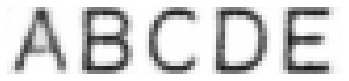

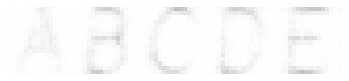

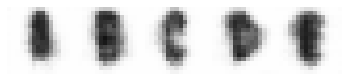

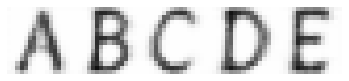

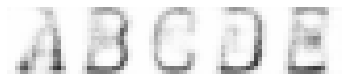

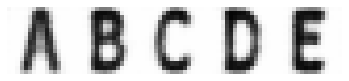

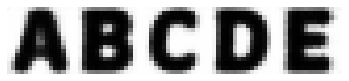

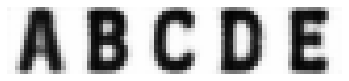

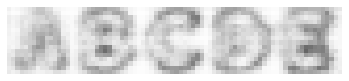

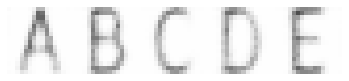

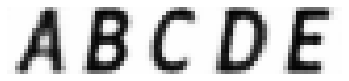

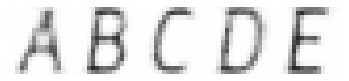

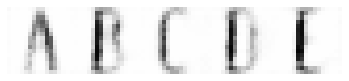

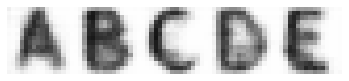

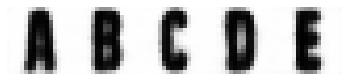

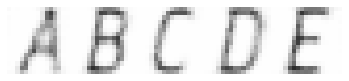

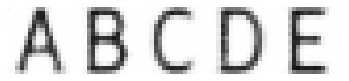

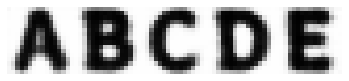

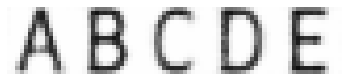

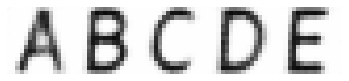

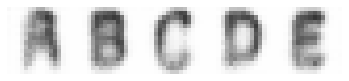

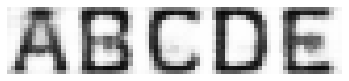

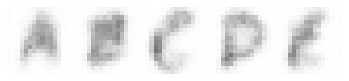

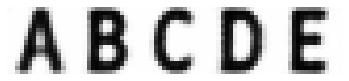

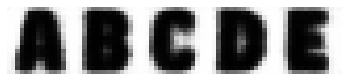

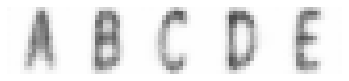

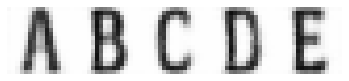

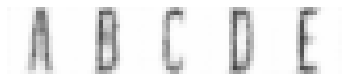

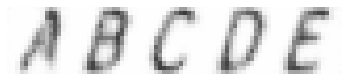

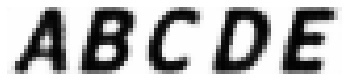

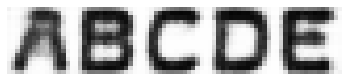

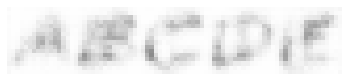

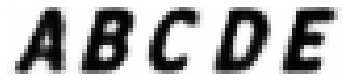

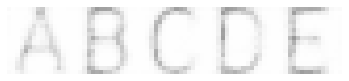

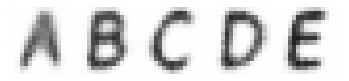

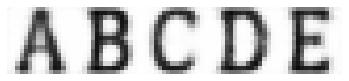

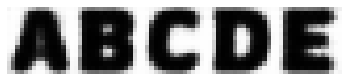

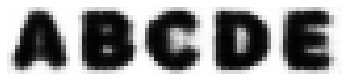

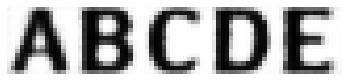

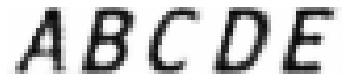

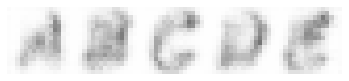

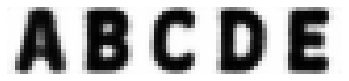

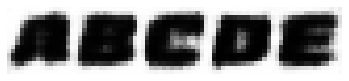

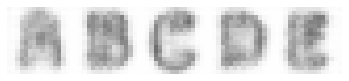

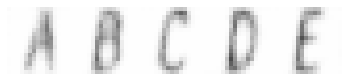

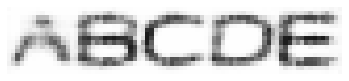

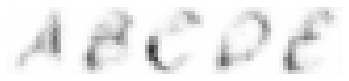

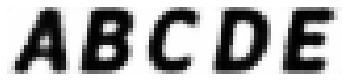

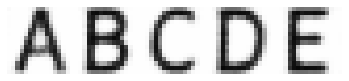

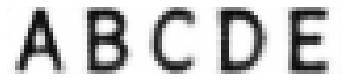

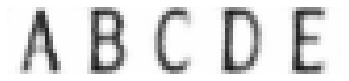

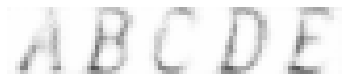

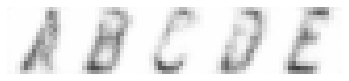

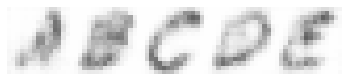

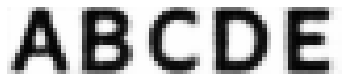

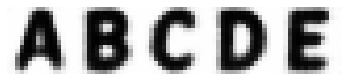

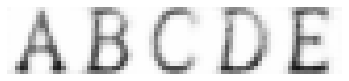

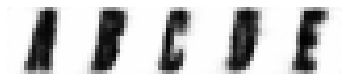

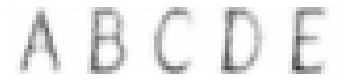

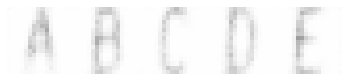

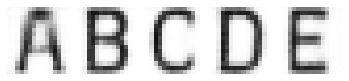

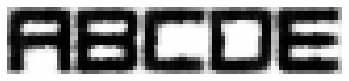

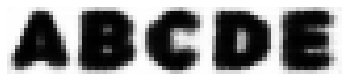

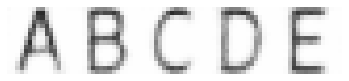

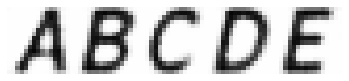

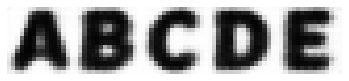

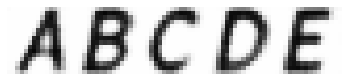

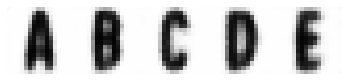

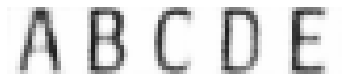

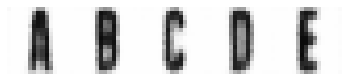

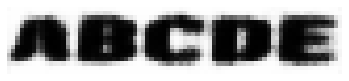

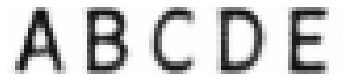

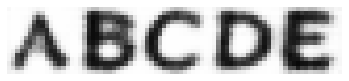

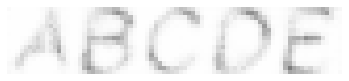

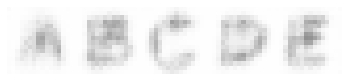

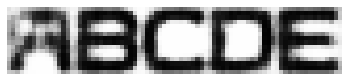

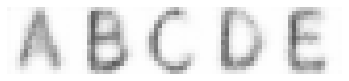

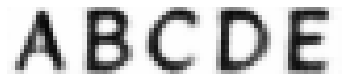

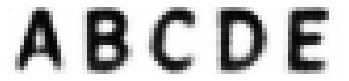

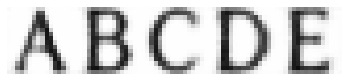

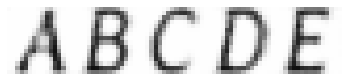

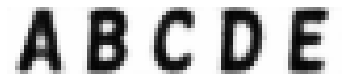

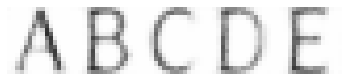

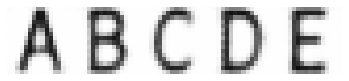

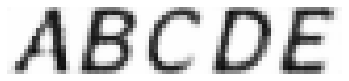

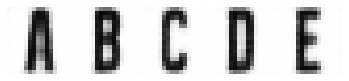

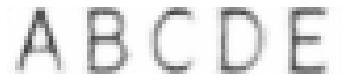

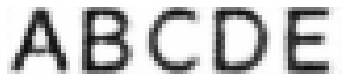

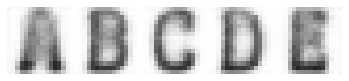

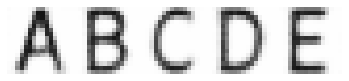

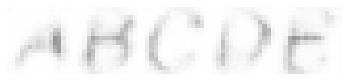

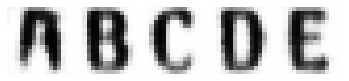

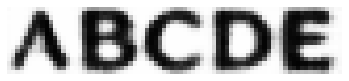

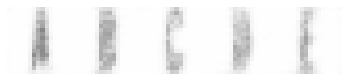

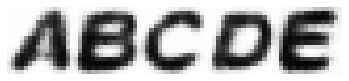

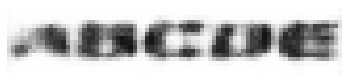

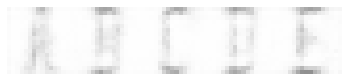

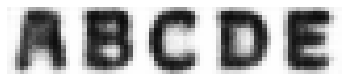

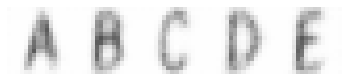

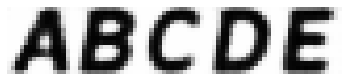

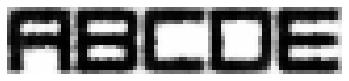

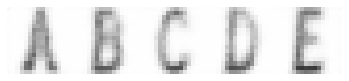

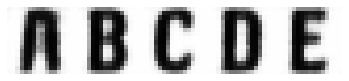

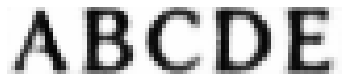

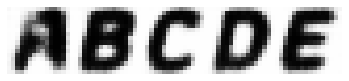

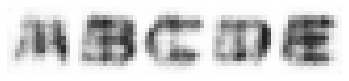

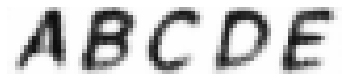

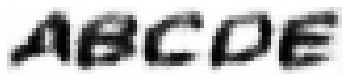

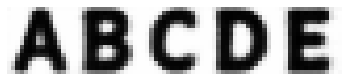

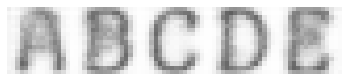

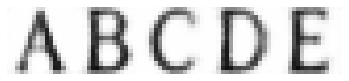

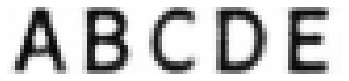

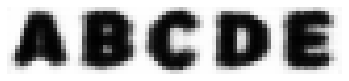

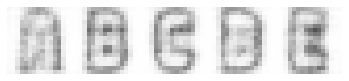

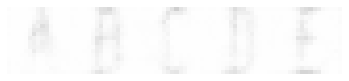

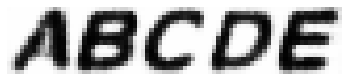

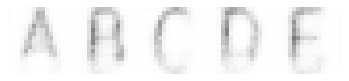

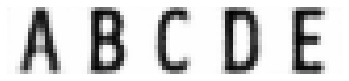

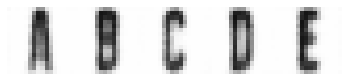

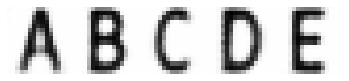

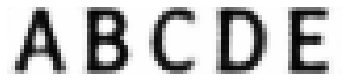

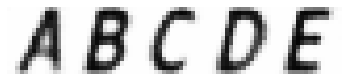

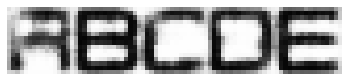

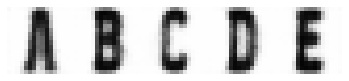

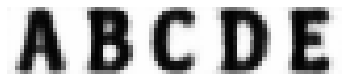

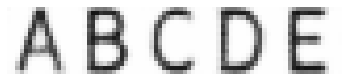

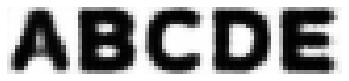

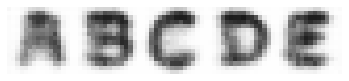

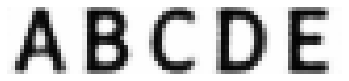

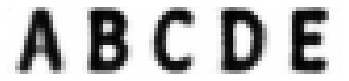

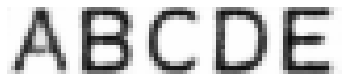

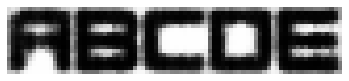

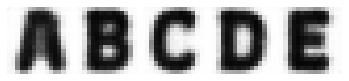

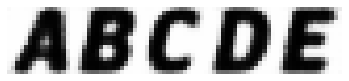

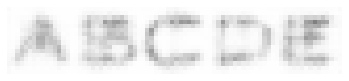

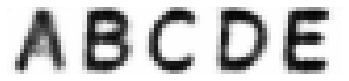

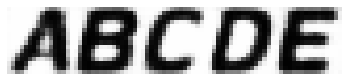

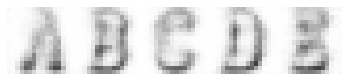

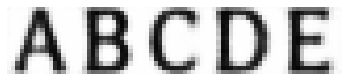

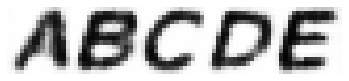

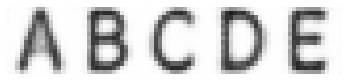

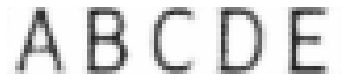

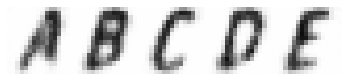

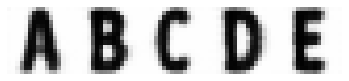

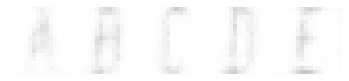

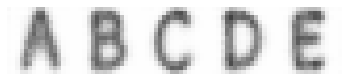

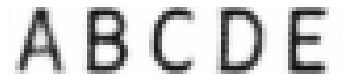

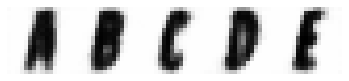

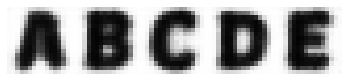

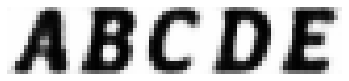

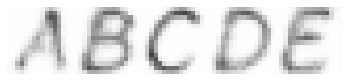

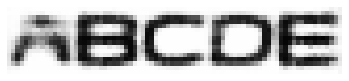

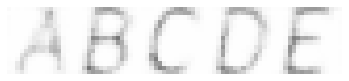

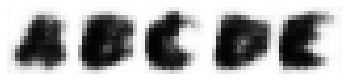

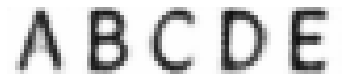

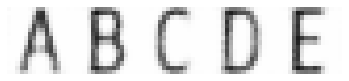

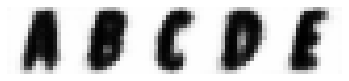

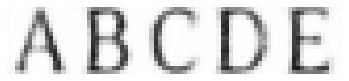

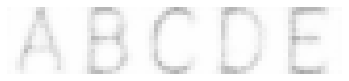

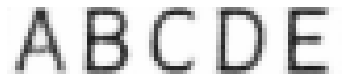

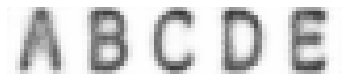

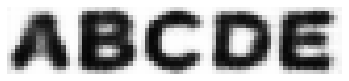

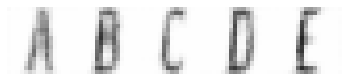

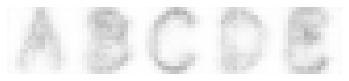

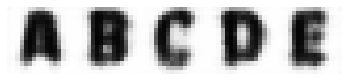

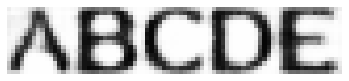

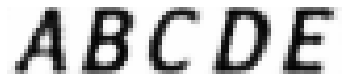

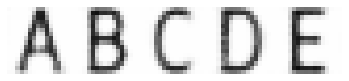

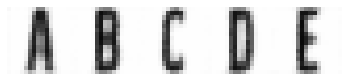

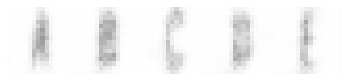

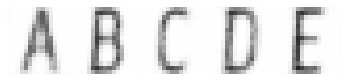

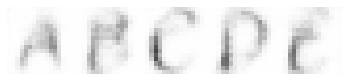

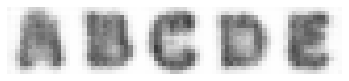

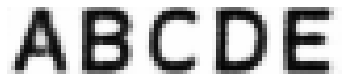

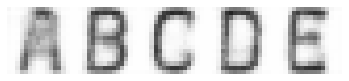

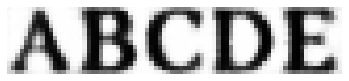

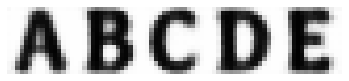

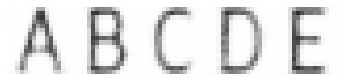

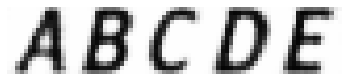

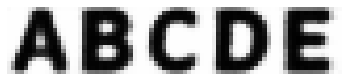

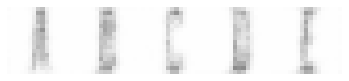

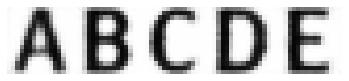

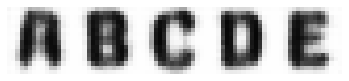

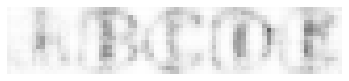

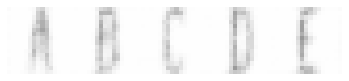

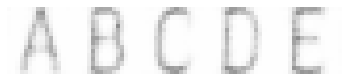

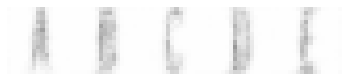

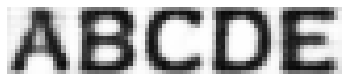

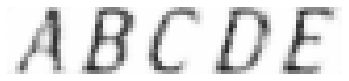

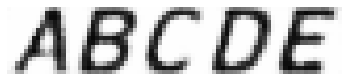

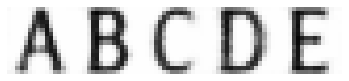

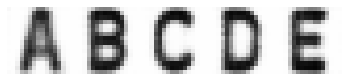

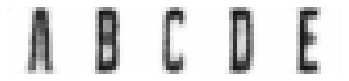

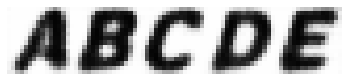

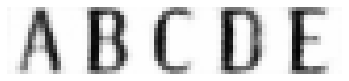

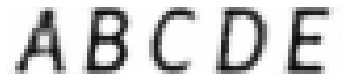

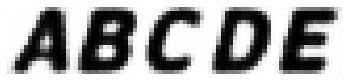

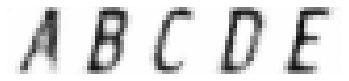

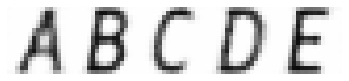

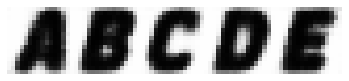

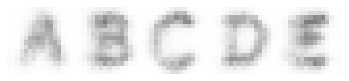

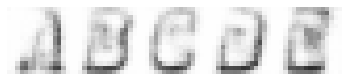

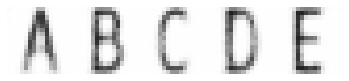

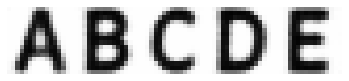

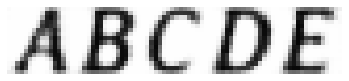

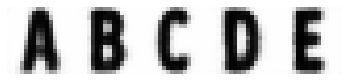

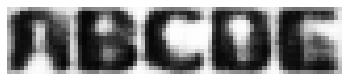

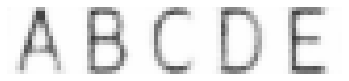

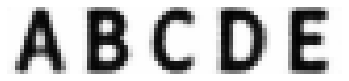

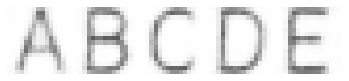

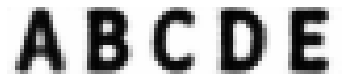

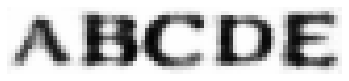

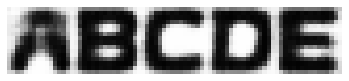

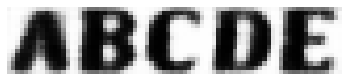

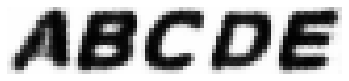

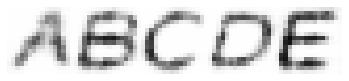

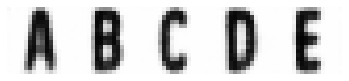

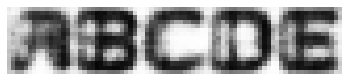

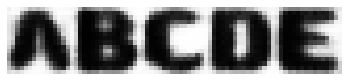

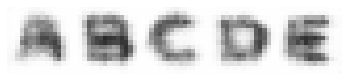

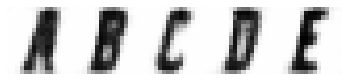

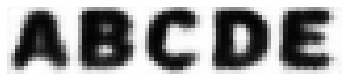

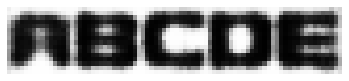

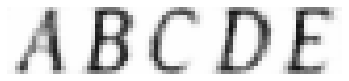

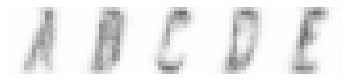

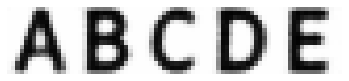

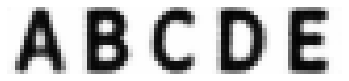

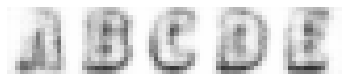

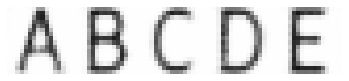

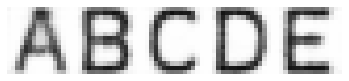

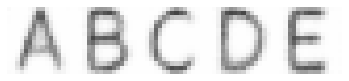

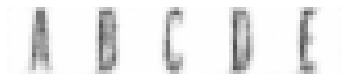

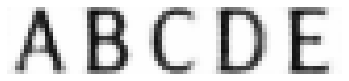

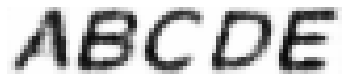

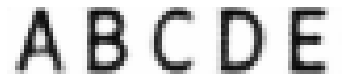

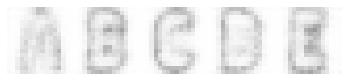

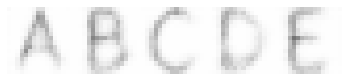

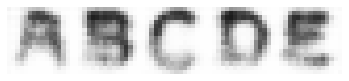

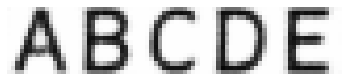

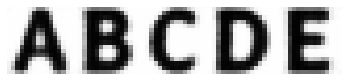

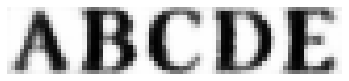

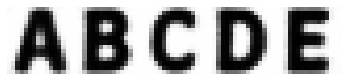

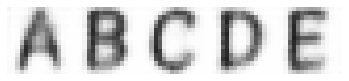

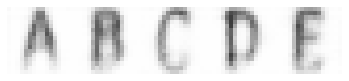

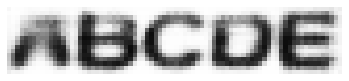

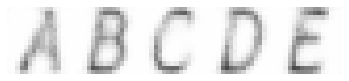

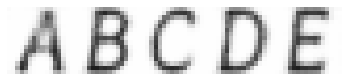

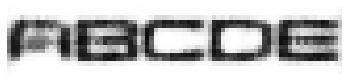

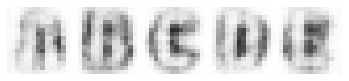

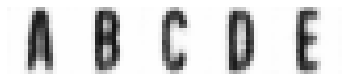

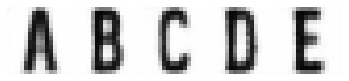

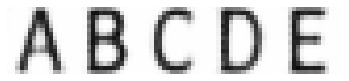

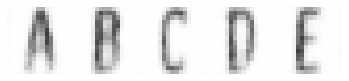

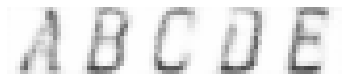

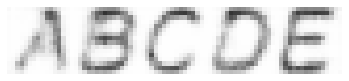

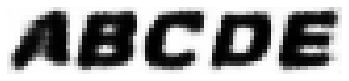

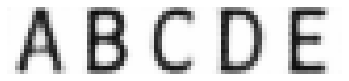

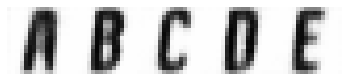

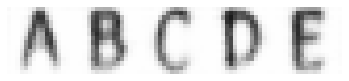

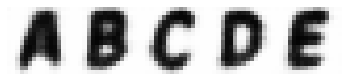

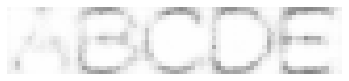

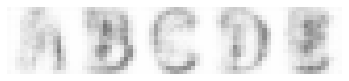

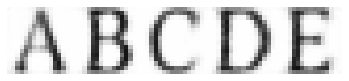

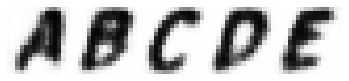

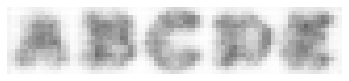

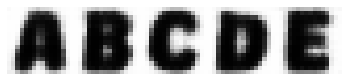

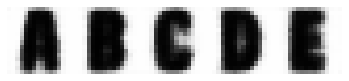

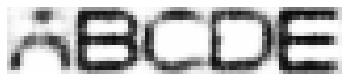

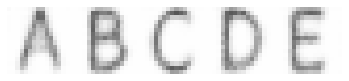

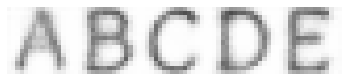

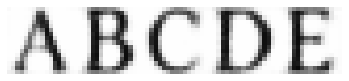

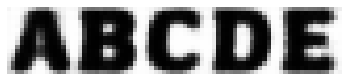

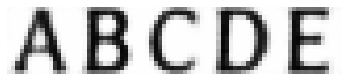

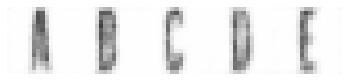

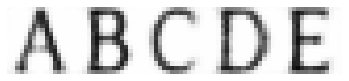

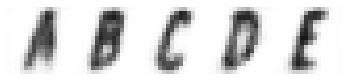

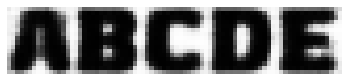

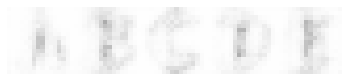

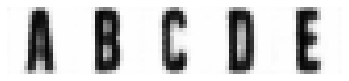

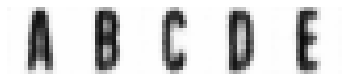

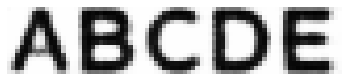

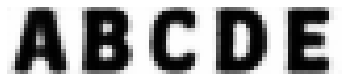

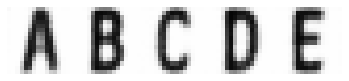

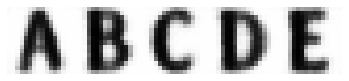

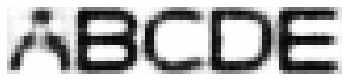

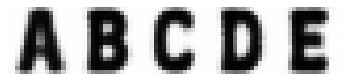

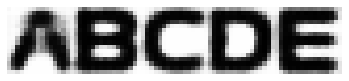

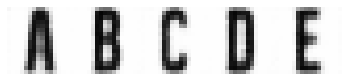

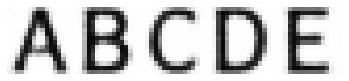

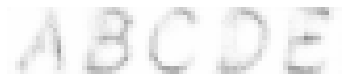

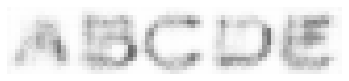

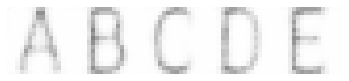

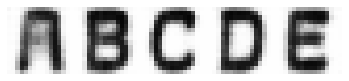

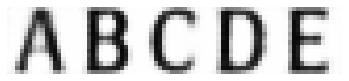

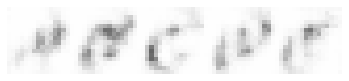

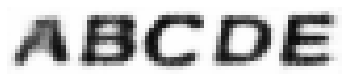

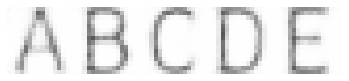

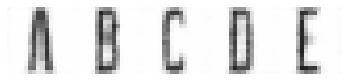

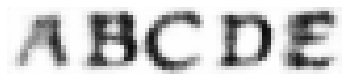

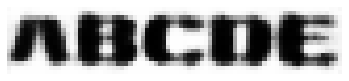

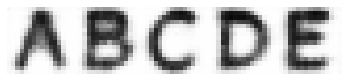

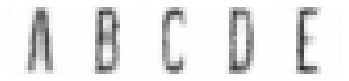

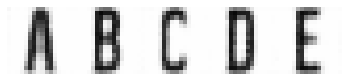

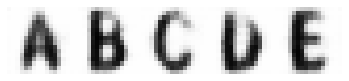

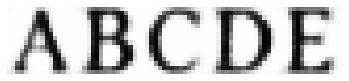

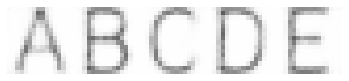

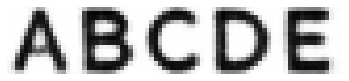

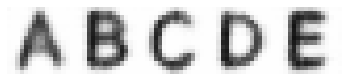

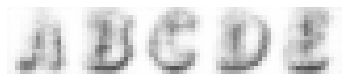

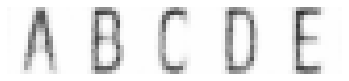

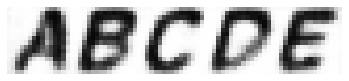

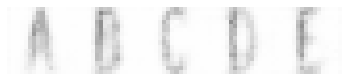

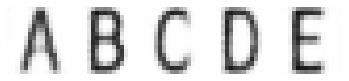

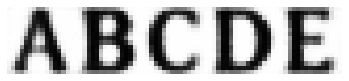

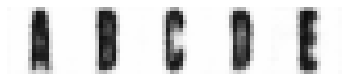

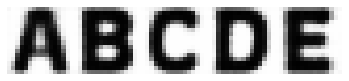

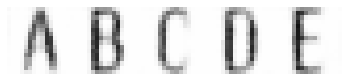

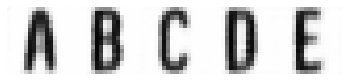

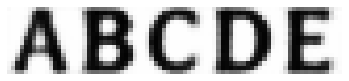

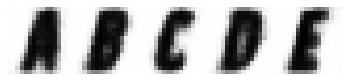

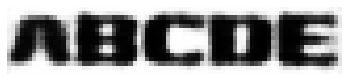

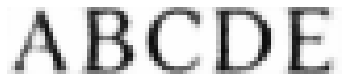

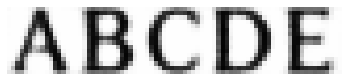

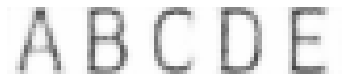

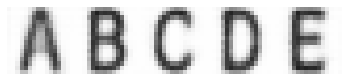

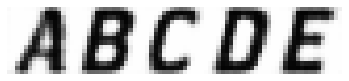

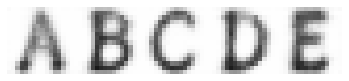

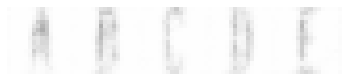

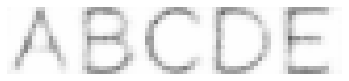

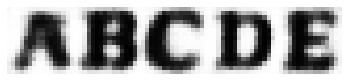

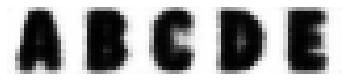

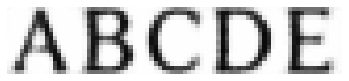

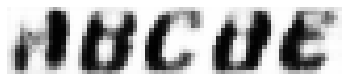

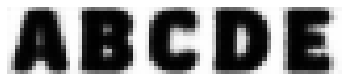

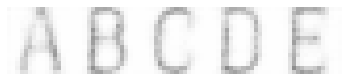

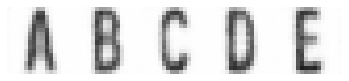

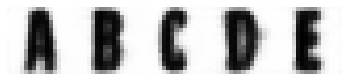

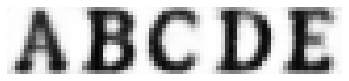

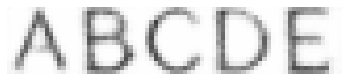

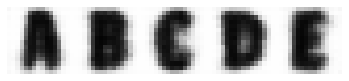

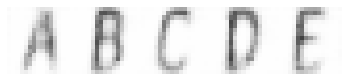

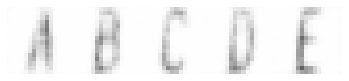

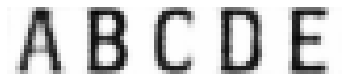

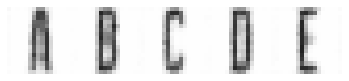

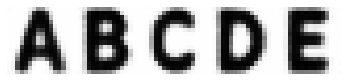

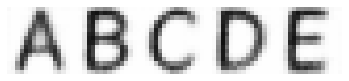

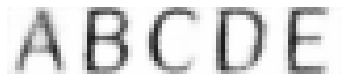

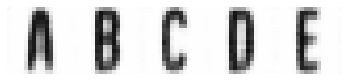

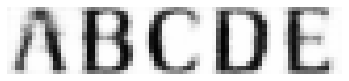

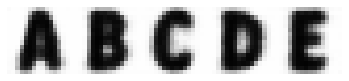

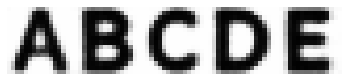

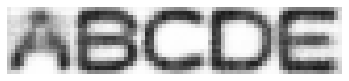

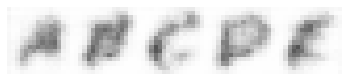

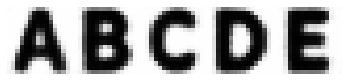

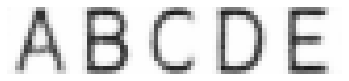

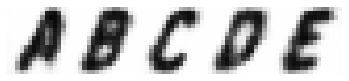

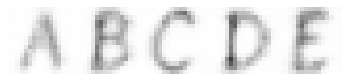

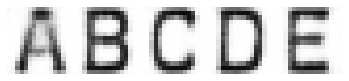

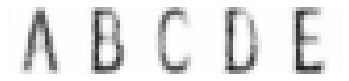

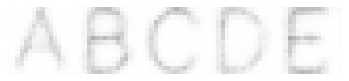

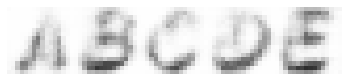

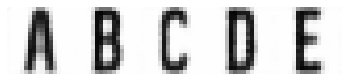

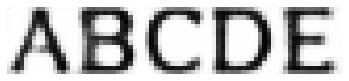

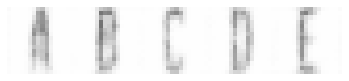

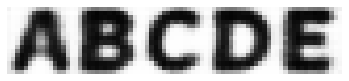

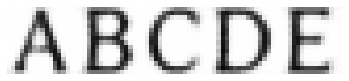

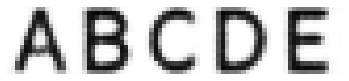

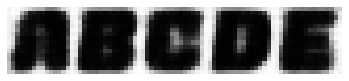

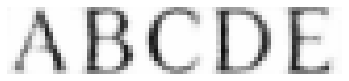

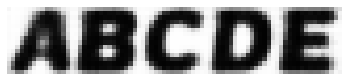

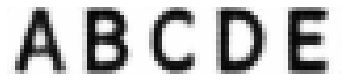

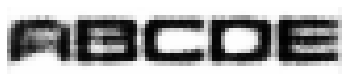

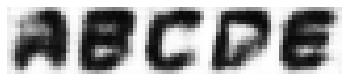

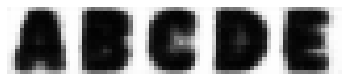

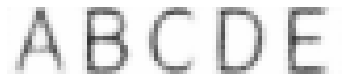

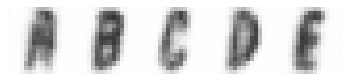

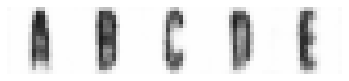

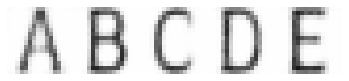

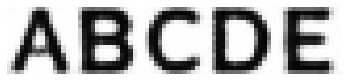

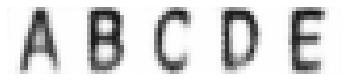

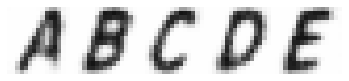

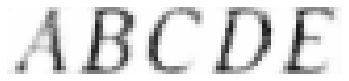

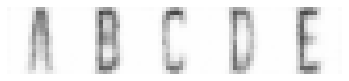

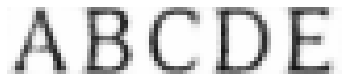

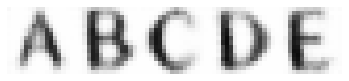

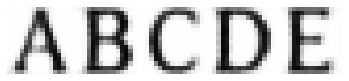

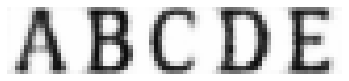

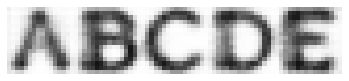

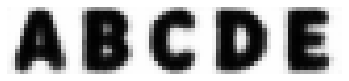

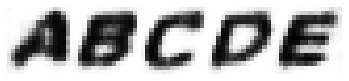

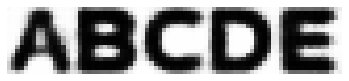

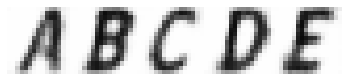

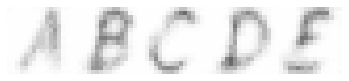

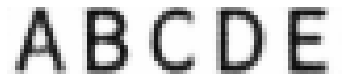

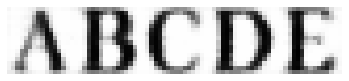

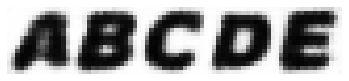

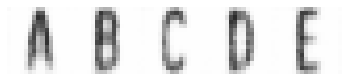

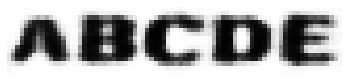

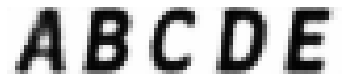

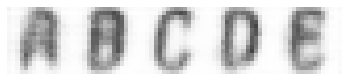

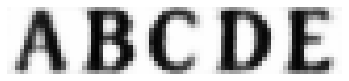

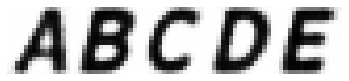

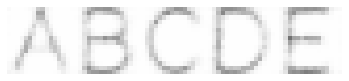

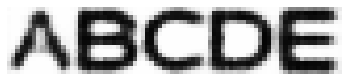

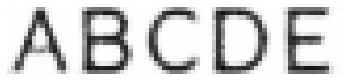

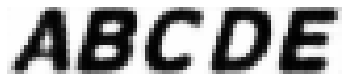

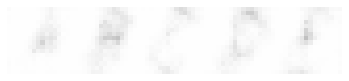

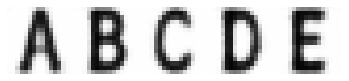

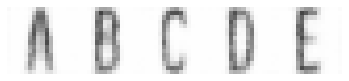

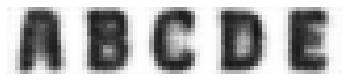

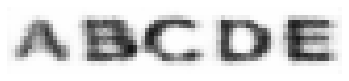

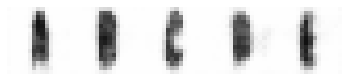

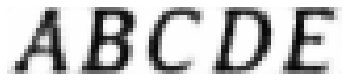

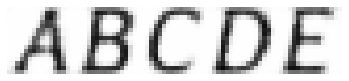

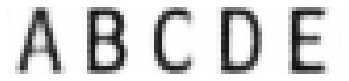

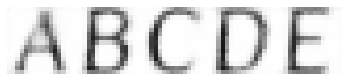

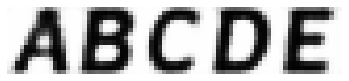

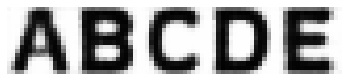

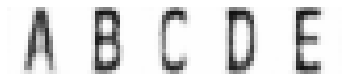

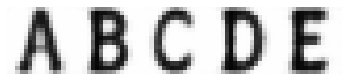

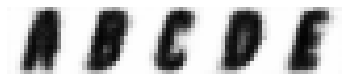

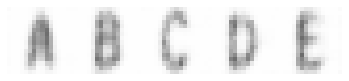

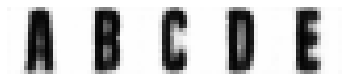

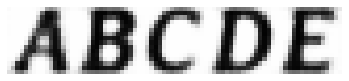

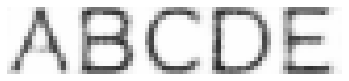

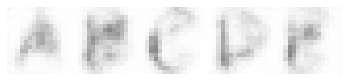

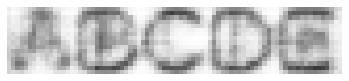

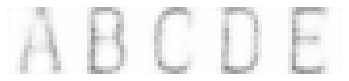

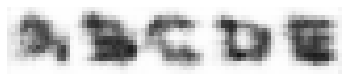

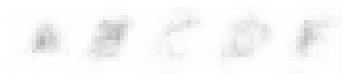

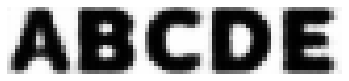

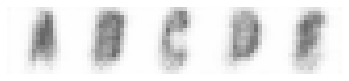

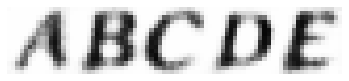

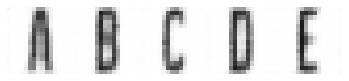

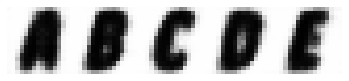

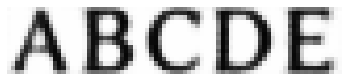

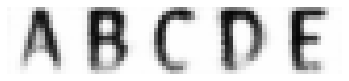

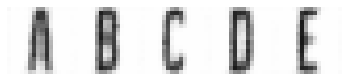

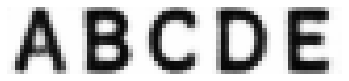

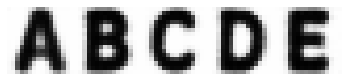

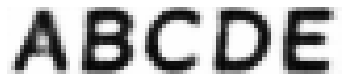

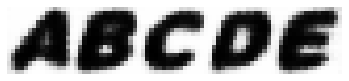

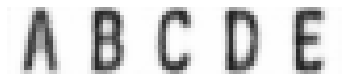

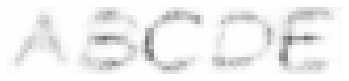

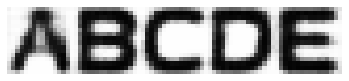

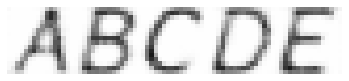

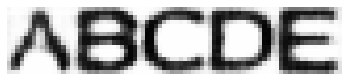

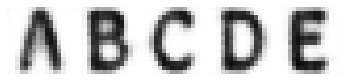

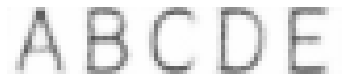

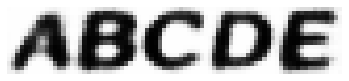

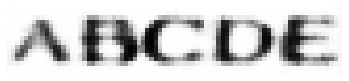

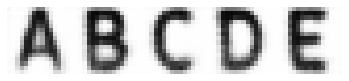

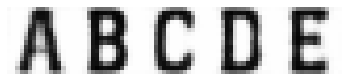

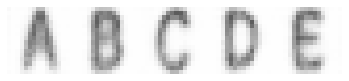

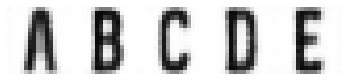

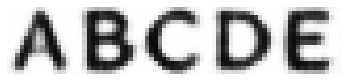

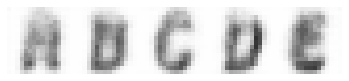

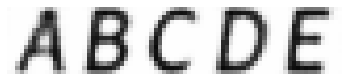

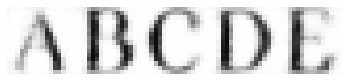

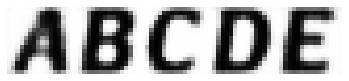

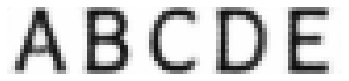

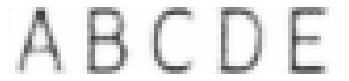

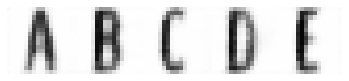

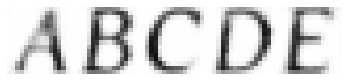

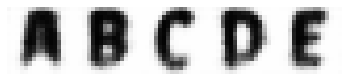

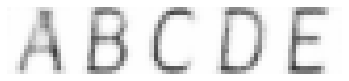

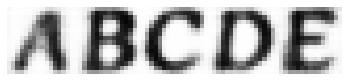

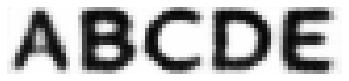

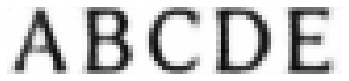

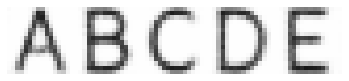

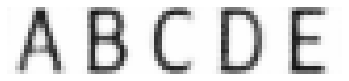

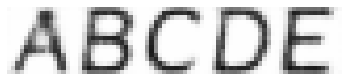

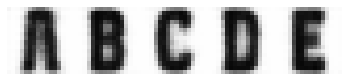

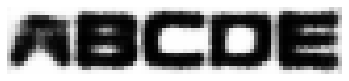

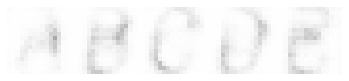

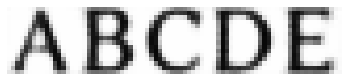

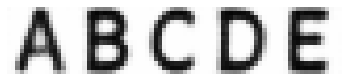

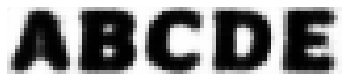

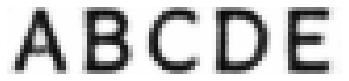

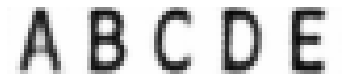

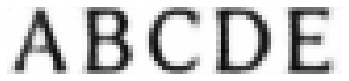

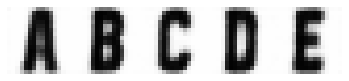

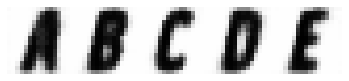

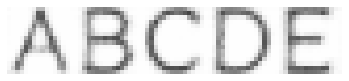

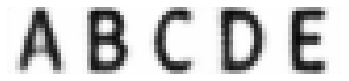

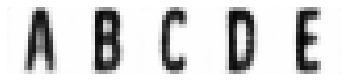

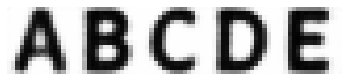

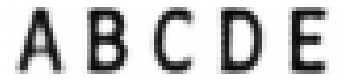

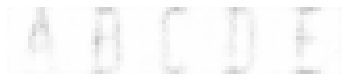

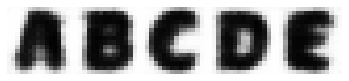

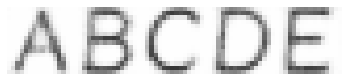

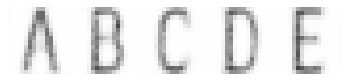

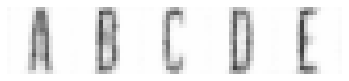

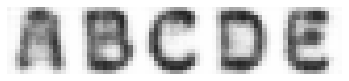

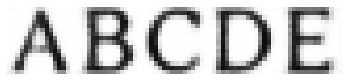

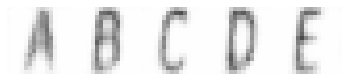

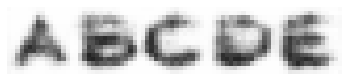

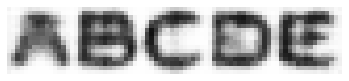

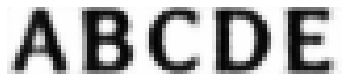

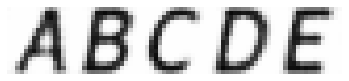

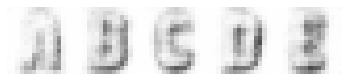

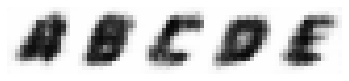

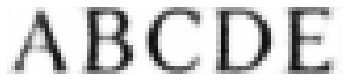

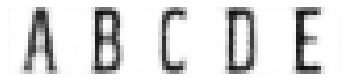

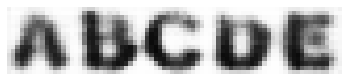

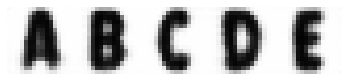

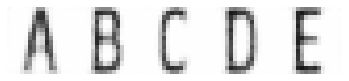

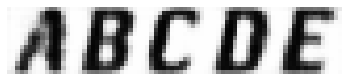

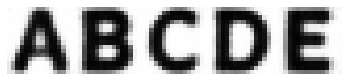

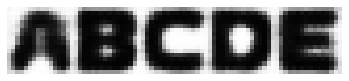

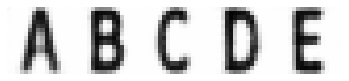

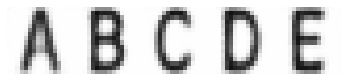

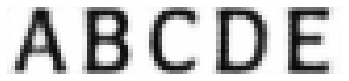

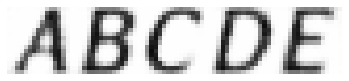

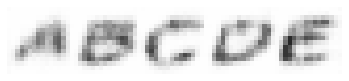

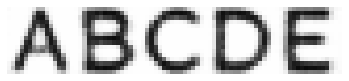

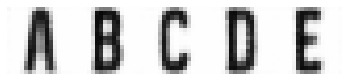

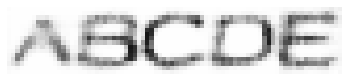

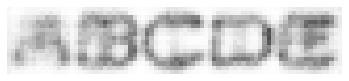

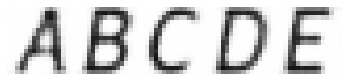

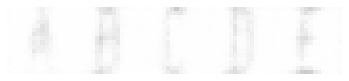

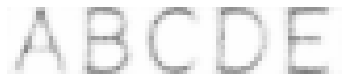

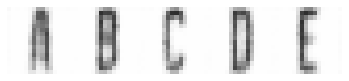

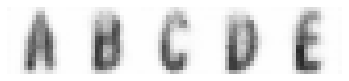

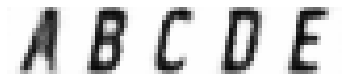

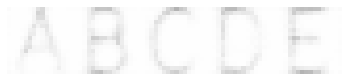

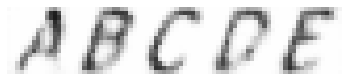

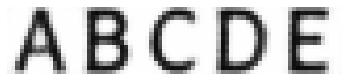

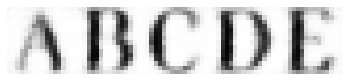

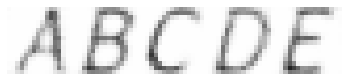

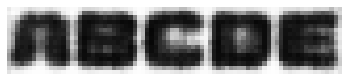

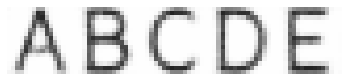

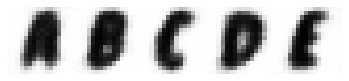

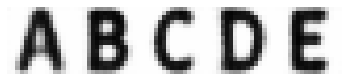

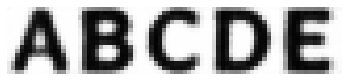

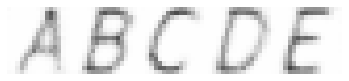

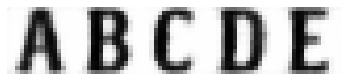

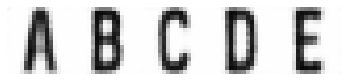

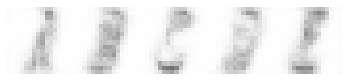

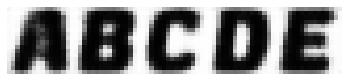

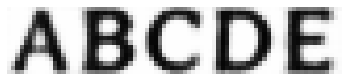

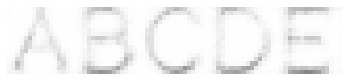

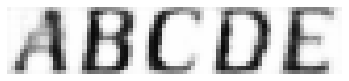

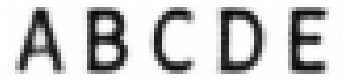

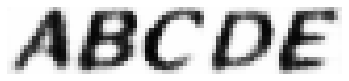

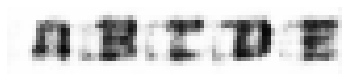

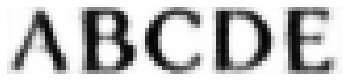

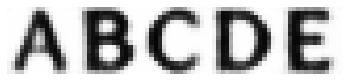

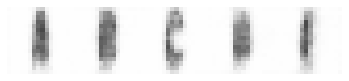

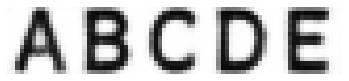

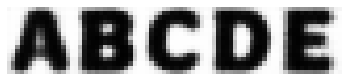

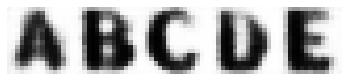

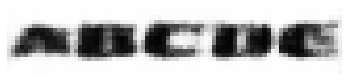

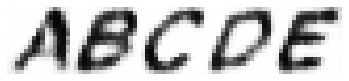

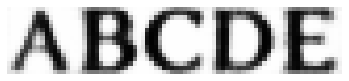

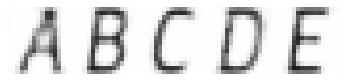

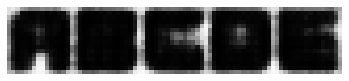

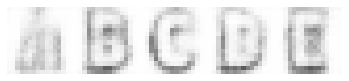

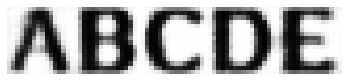

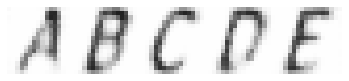

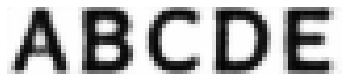

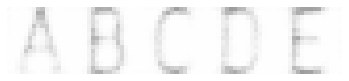

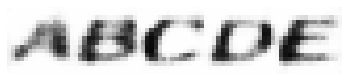

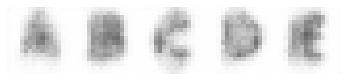

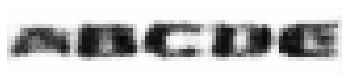

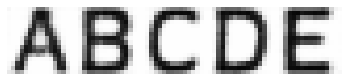

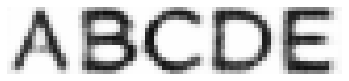

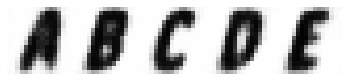

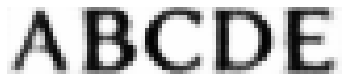

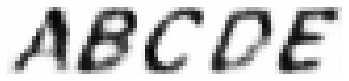

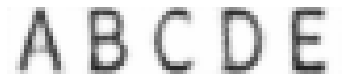

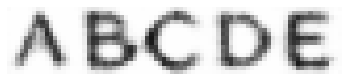

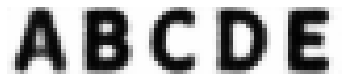

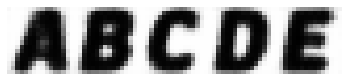

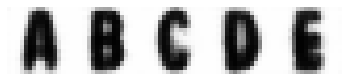

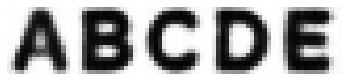

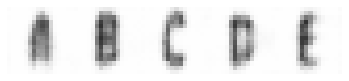

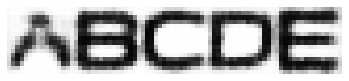

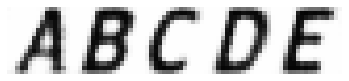

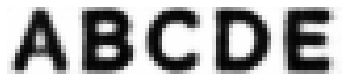

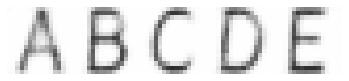

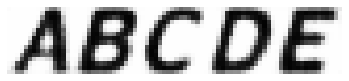

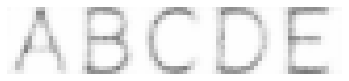

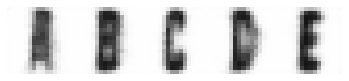

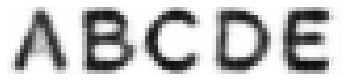

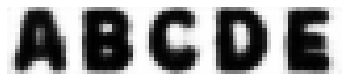

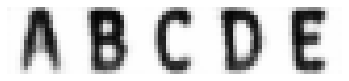

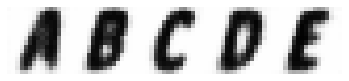

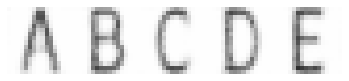

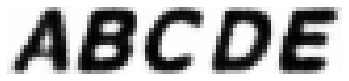

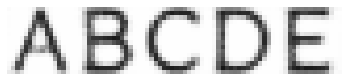

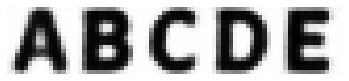

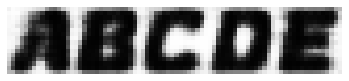

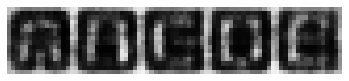

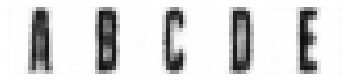

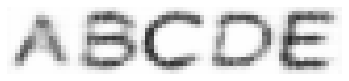

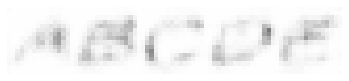

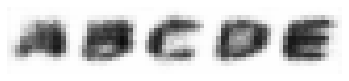

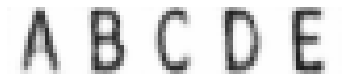

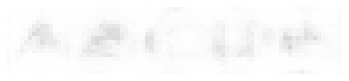

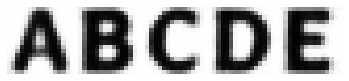

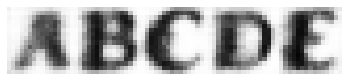

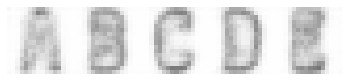

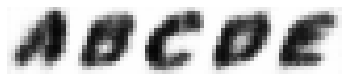

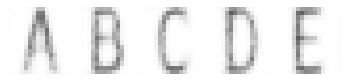

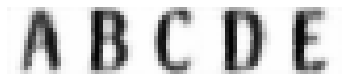

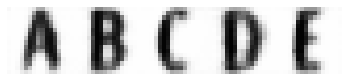

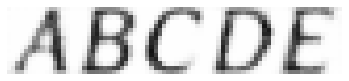

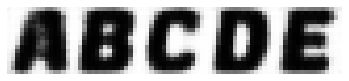

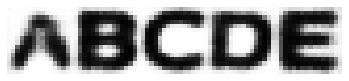

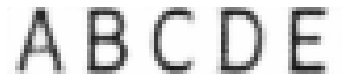

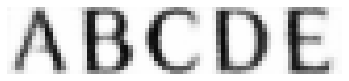

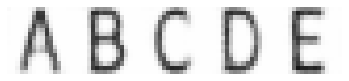

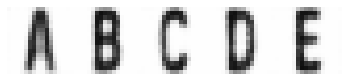

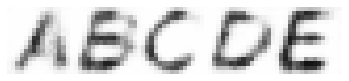

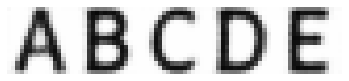

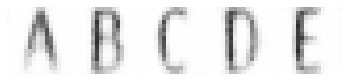

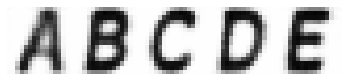

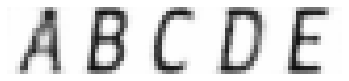

KeyboardInterrupt: 

In [77]:
from train import prepare_generator_input

for data in test_loader:
    if len(data) % batch_size != 0:
      continue
    data = data.type(data_type)
    
    generator_input = prepare_generator_input(data, glyph_size, glyphs_per_image)
    generated_images = SuperG(generator_input)
    
    for image in generated_images:
        show_grayscale_image(image.cpu())

Input


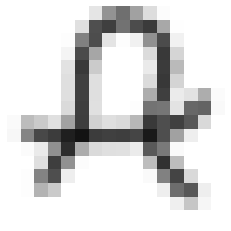

Output


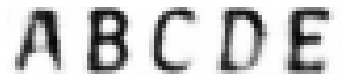

Input


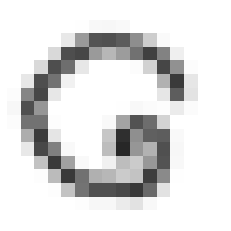

Output


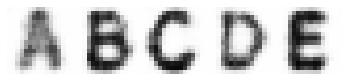

Input


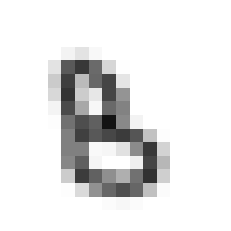

Output


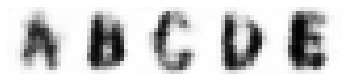

Input


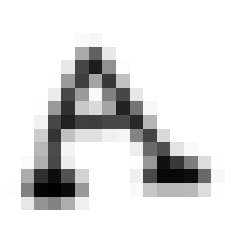

Output


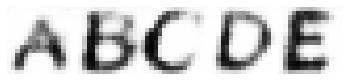

Input


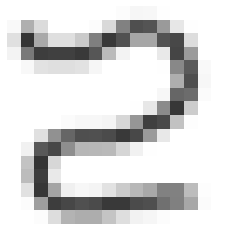

Output


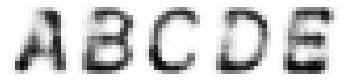

Input


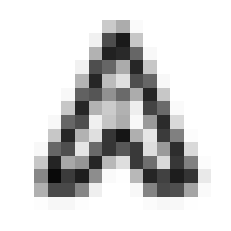

Output


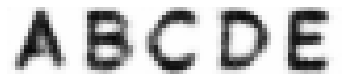

Input


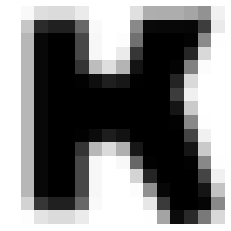

Output


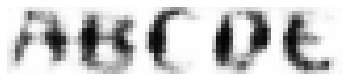

In [82]:
handdrawn_dataset = dataset = FontDataset('./datasets/test_images/', glyph_size=glyph_size, glyphs_per_image=1)
handdrawn_dataloader = FontDataLoader(handdrawn_dataset, sampler=None, batch_size=1)

for data in handdrawn_dataloader:
    data = data.type(data_type)
    generated_images = SuperG(data)
    
    for image in generated_images:
        print("Input")
        show_grayscale_image(data[0].cpu())
        print("Output")
        show_grayscale_image(image.cpu())

In [ ]:
for data in data_loader:
    show_grayscale_image(data[0])
    print(D(data.type(data_type)))
    break
#     # For now, only use A
#     generated = G(data[0:1,:,:,0:64].type(data_type))
    
#     # Flatten the generated shape
#     generated_shape = generated.shape
#     generated = generated.reshape(generated_shape[0], generated_shape[1], 64, 2048)
#     print(generated.shape)
    
#     # Extract only letters A-Z (ignore blank space) (64 x 26 = 1664)
# #     generated = generated[:, :, :, 0:1664]
    
#     plt.imshow(transforms.Compose([
#         transforms.ToPILImage('L')
#     ])(generated[0].cpu()))
#     break
    